In [1]:
# IMPORTING DATASETS AND REQUIRED LIBRARIES

import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier,SGDClassifier
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
df2 = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')
print(df.shape)


(100000, 76)


# EDA

In [2]:
#DROPPING DUPLICATES IN ORDER TO IMPROVE THE MODEL TRAINING IN THE FUTURE
df=df.drop_duplicates()
print(df.shape)


(99835, 76)


The dataset initially had shape **(100000,76)** and after dropping duplicates the shape reduced to **(99835,76)**

In [3]:
# CHECKING FOR NULL COLUMNS
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 99835 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   MachineID                           99835 non-null  object 
 1   ProductName                         99835 non-null  object 
 2   EngineVersion                       99835 non-null  object 
 3   AppVersion                          99835 non-null  object 
 4   SignatureVersion                    99835 non-null  object 
 5   IsBetaUser                          99835 non-null  int64  
 6   RealTimeProtectionState             99769 non-null  float64
 7   IsPassiveModeEnabled                99835 non-null  int64  
 8   AntivirusConfigID                   99759 non-null  float64
 9   NumAntivirusProductsInstalled       99759 non-null  float64
 10  NumAntivirusProductsEnabled         99759 non-null  float64
 11  HasTpm                              99835 non-


* All of the columns have **non null** values.
* The mean of the columns are very less than the maximum values indicating the **presence of outliers**.


In [4]:
#CHECKING STATS FOR CATEGORICAL COLUMNS
print(df.describe(include='object'))

                               MachineID   ProductName EngineVersion  \
count                              99835         99835         99835   
unique                             99835             2            37   
top     f541bae429089117c4aac39c90dd3416  win8defender   1.1.15200.1   
freq                                   1         99606         45147   

             AppVersion SignatureVersion PlatformType Processor OSVersion  \
count             99835            99835        99835     99835     99835   
unique               69             2735            4         3         7   
top     4.18.1807.18075     1.273.1420.0    windows10       x64  10.0.0.0   
freq              62018             1273        98183     91110     98207   

       OsPlatformSubRelease                                OSBuildLab  ...  \
count                 99835                                     99835  ...   
unique                    9                                       281  ...   
top                


* The count and the nuniques values for **MachineId** are same which can be **considered for removal** for the columns [IsBetaUser,AutoSampleSubmissionEnabled,IsFlightsDisabled] **nunique==1** for the rest of the columns nunique is varying.


In [5]:
# SEPARATING THE TARGET COLUMNS FROM THE TRAINING DATA 
y = df['target']
X = df.drop(columns='target')
# STORING SEPARATE LISTS FOR NUMERICAL & CATEGORICAL COLUMNS
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

In [6]:
# CALCULATING CORRELATION COEFFICIENT OF CATEGORICAL COLUMNS 
#WITH THE TARGET VARIABLE, DIPLAYING IN DESCENDING ORDER
corr=df[num_cols].corrwith(df['target'])
corr=corr.sort_values(ascending=False)
print(corr)

AntivirusConfigID                     0.118205
TotalPhysicalRAMMB                    0.065643
IsSystemProtected                     0.062468
IsGamer                               0.061213
ProcessorCoreCount                    0.056899
PrimaryDiskCapacityMB                 0.049080
RealTimeProtectionState               0.049079
OSBuildNumberOnly                     0.038667
PrimaryDisplayDiagonalInches          0.035297
OSBuildNumber                         0.034837
PrimaryDisplayResolutionHorizontal    0.030607
IEVersionID                           0.023891
HasOpticalDiskDrive                   0.022401
ProcessorModelID                      0.021862
InternalBatteryNumberOfCharges        0.017456
LocaleEnglishNameID                   0.015435
SystemVolumeCapacityMB                0.013855
PrimaryDisplayResolutionVertical      0.011287
FirewallEnabled                       0.010213
HasTpm                                0.007666
IsPortableOS                          0.006412
CountryID    

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


**The error arises due to the fact that the last three columns contain only one value i.e 0**

In [7]:
# CHECKING FOR CLASS IMBALANCE
class_counts= df['target'].value_counts()
print(class_counts)
class_ratio = class_counts / len(df)
print("\nClass Ratio:\n", class_ratio)
print("\nImbalance Ratio:", class_counts.min() / class_counts.max())

target
1    50443
0    49392
Name: count, dtype: int64

Class Ratio:
 target
1    0.505264
0    0.494736
Name: count, dtype: float64

Imbalance Ratio: 0.9791646016295621


* The target column is **highly balanced** with **imbalance ratio = 0.98**

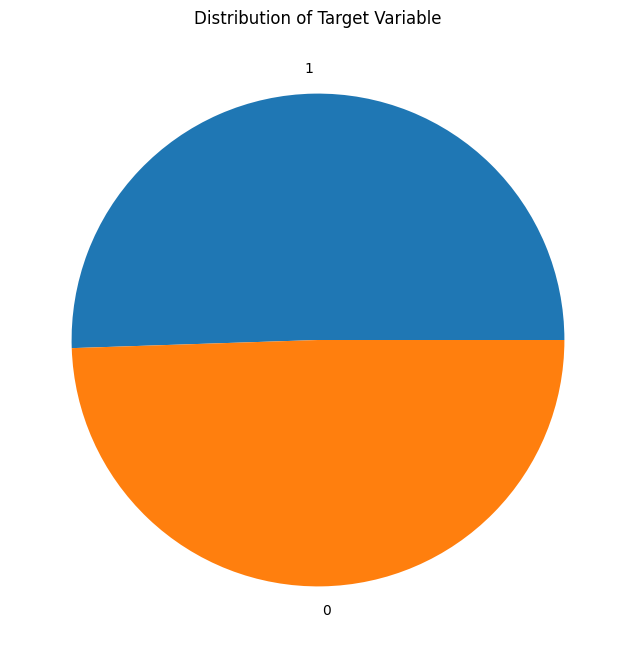

In [8]:
import matplotlib.pyplot as plt
# Count occurrences of each unique value
target_counts = df['target'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(target_counts, labels=target_counts.index)
plt.title("Distribution of Target Variable")
plt.show()


In [9]:
#COMPUTING Q1 & Q3 IN ORDER TO FIND IQR
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

#DEFINE LOWER & UPPER BOUNDS
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#CREATING A MASK FOR OUTLIERS
outlier_mask = (df[num_cols] < lower_bound) | (df[num_cols] > upper_bound)

#CALCULAING OUTLIERS PER COLUMN
outliers_count = outlier_mask.sum()
print("Outliers detected per column:\n", outliers_count)

Outliers detected per column:
 IsBetaUser                                0
RealTimeProtectionState                2557
IsPassiveModeEnabled                   1761
AntivirusConfigID                     19545
NumAntivirusProductsInstalled            95
NumAntivirusProductsEnabled            2253
HasTpm                                  322
CountryID                                 0
CityID                                    0
GeoRegionID                               0
LocaleEnglishNameID                       0
OSBuildNumber                         15954
OSProductSuite                            0
IsSystemProtected                      4455
AutoSampleSubmissionEnabled               0
SMode                                    50
IEVersionID                            4937
FirewallEnabled                        1987
EnableLUA                               484
OEMNameID                             10256
OEMModelID                              745
ProcessorCoreCount                    11125
P

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [10]:
# REMOVING OUTLIER WITH THE HOPE OF TRAINING THE MODELS BETTER
'''
# Remove rows containing any outliers
df_cleaned = df[~outlier_mask.any(axis=1)]

# Print dataset shape before and after outlier removal
print(f"Original dataset shape: {df.shape}")
print(f"After outlier removal: {df_cleaned.shape}")
print(df_cleaned['target'].value_counts())
'''

'\n# Remove rows containing any outliers\ndf_cleaned = df[~outlier_mask.any(axis=1)]\n\n# Print dataset shape before and after outlier removal\nprint(f"Original dataset shape: {df.shape}")\nprint(f"After outlier removal: {df_cleaned.shape}")\nprint(df_cleaned[\'target\'].value_counts())\n'

**Removing the outliers before training reduces the model accuracy. So it has been commented out**

In [11]:
# CHOOSING SOME COLUMNS OF INTEREST AGAINST THE TARGET VARIABLE & OBSERVING THROUGH CROSSTAB 
cols=['NumAntivirusProductsInstalled','ProductName','RealTimeProtectionState','PlatformType','Processor','FirewallEnabled',
      'IsSystemProtected','AutoUpdateOptionsName','OSGenuineState','LicenseActivationChannel','IsSecureBootEnabled',
      'IsGamer']
for i in cols:
    print(pd.crosstab(index=df[i],columns=df['target']))

target                             0      1
NumAntivirusProductsInstalled              
1.0                            31014  38625
2.0                            16685  11088
3.0                             1575    677
4.0                               63     27
5.0                                4      1
target            0      1
ProductName               
mse             125    104
win8defender  49267  50339
target                       0      1
RealTimeProtectionState              
0.0                       1369    742
1.0                          6      5
3.0                         12      7
5.0                        179     31
7.0                      47734  49478
8.0                         53    153
target            0      1
PlatformType              
windows10     48560  49623
windows2016      21      8
windows7        124    102
windows8        687    710
target         0      1
Processor              
arm64          4      1
x64        44041  47069
x86         5347   337

The following were the observed:


* **NumAntivirusProductsInstalled**: With the increase in Version no. the percentage of threat occurences reduced
* **ProductName**: The threat occurence is *independent* of ProductName for** mse and Win8defender**.
* **RealTimeProtectionState**: The *0.0* and *5.0* are found to be most secure states, The *7.0* and *8.0* are the most vulnerable states
* **PlatformType**: The threat occurence is *independent* of Platform Type**Processor**: The threat occurence is mostly *independent* .*arm64 and x86 are better options*
* **FirewallEnabled,IsSystemProtected**: The threat occurence is also *mostly independent* as **mse and Win8defender** doesn't have any significant impact but *actually puts the system under threat*.
* **LicenseActivationChannel**: **OEM:NONSLP & Retail:TB:Eval** have relatively *less chances* while as     **Volume:GVLK** makes system *more vulnerable*.
* **IsGamer**: Gamers have *increased chances* of putting system under threat.
* 



In [12]:
'''
# IMPORTING VISUALIZATION LIBRARIES
import matplotlib.pyplot as plt
import seaborn as sns

if 'target' in num_cols:
    num_cols.remove('target')
# ONLY PLOTTING COLUMNS WITH MAX CATEGORIES<=15

MAX_CATEGORIES = 15  

for col in num_cols:
    #CHECKING UNIQUE VALUES
    unique_values = df[col].nunique()

    if unique_values > MAX_CATEGORIES:
        print(f"Skipping {col} (Too many unique values: {unique_values})")
        continue  # Skip columns with too many unique values

    # CREATING CROSSTABTAB TO CALCULATE PROPORTIONS
    cross_tab = pd.crosstab(df[col], df['target'], normalize='index') * 100

    # CREATING STACKED BAR CHART
    cross_tab.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')

    plt.title(f"Proportion of Target Variable in {col}")
    plt.xlabel(col)
    plt.ylabel("Percentage")
    plt.xticks(rotation=45)
    plt.legend(title="Target", loc='upper right')
    plt.show()
'''

'\n# IMPORTING VISUALIZATION LIBRARIES\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\nif \'target\' in num_cols:\n    num_cols.remove(\'target\')\n# ONLY PLOTTING COLUMNS WITH MAX CATEGORIES<=15\n\nMAX_CATEGORIES = 15  \n\nfor col in num_cols:\n    #CHECKING UNIQUE VALUES\n    unique_values = df[col].nunique()\n\n    if unique_values > MAX_CATEGORIES:\n        print(f"Skipping {col} (Too many unique values: {unique_values})")\n        continue  # Skip columns with too many unique values\n\n    # CREATING CROSSTABTAB TO CALCULATE PROPORTIONS\n    cross_tab = pd.crosstab(df[col], df[\'target\'], normalize=\'index\') * 100\n\n    # CREATING STACKED BAR CHART\n    cross_tab.plot(kind=\'bar\', stacked=True, figsize=(12, 6), colormap=\'coolwarm\')\n\n    plt.title(f"Proportion of Target Variable in {col}")\n    plt.xlabel(col)\n    plt.ylabel("Percentage")\n    plt.xticks(rotation=45)\n    plt.legend(title="Target", loc=\'upper right\')\n    plt.show()\n'

**Among all the numerical type columns,the following columns are taken into consideration:** 
*RealtimeProtectionState,NumAntivirusProductsInstalled,OSProductSuite,SMode,ProcessorManufacturerID,IsVirtualDevice*
.

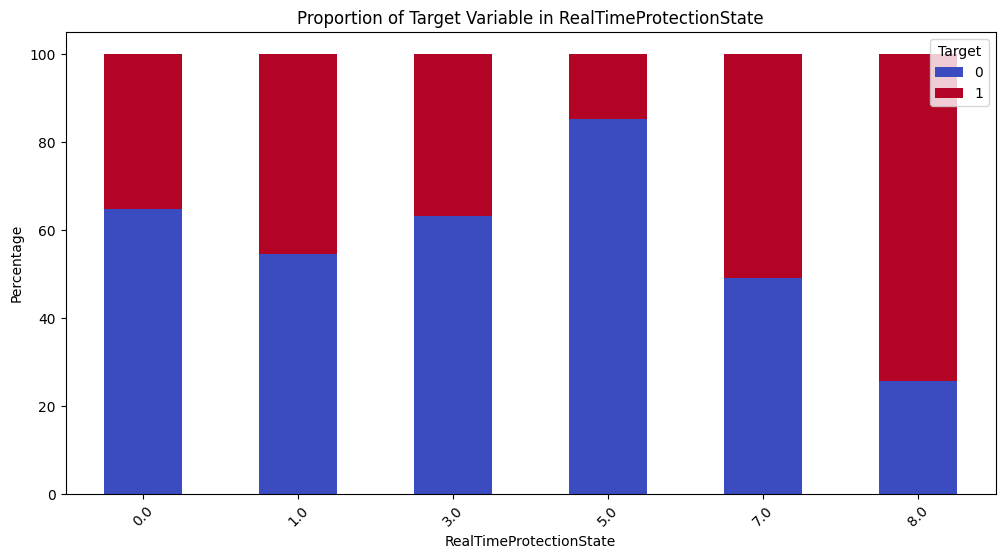

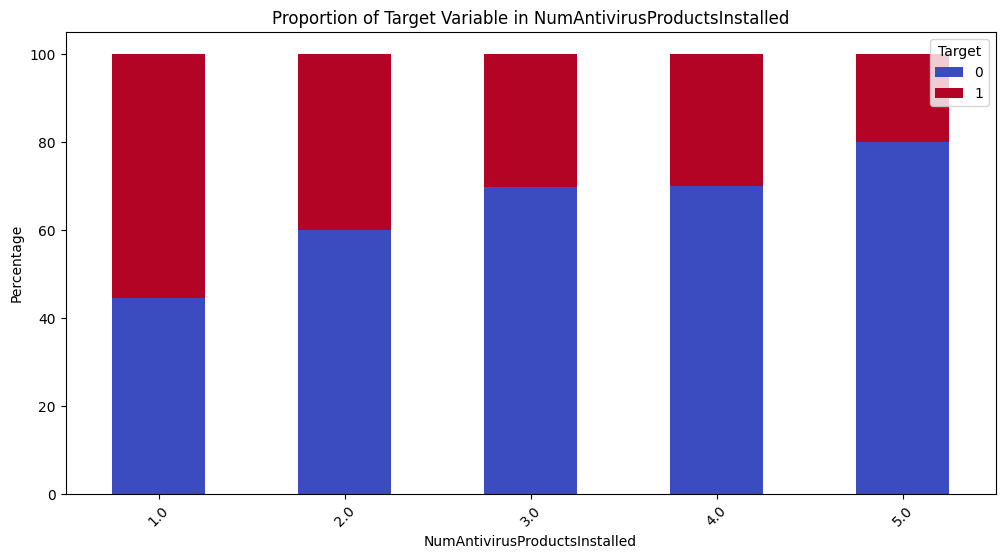

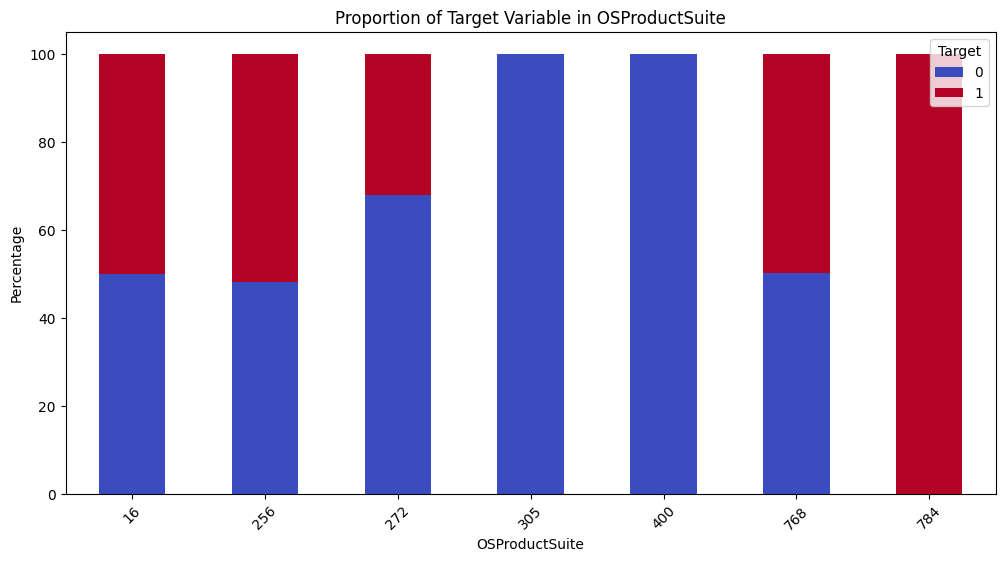

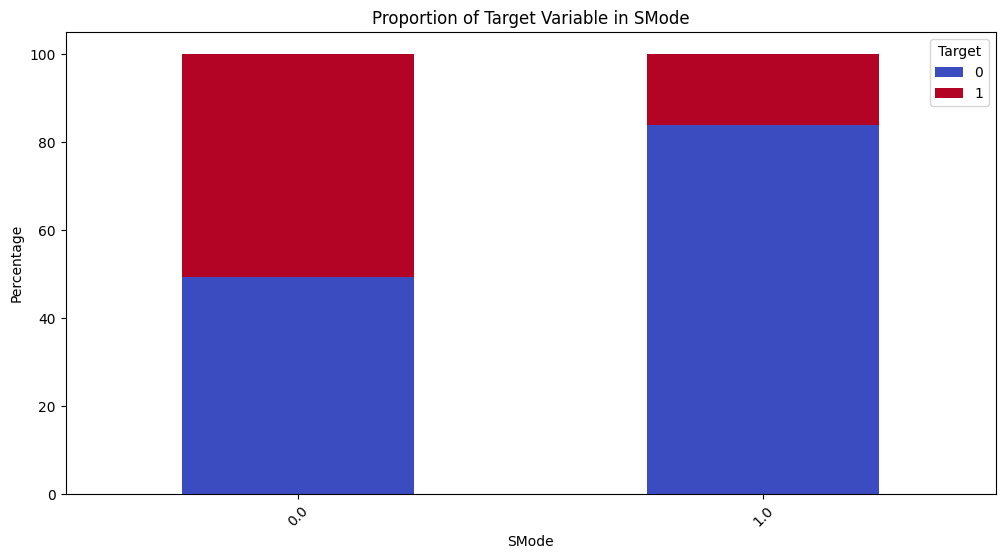

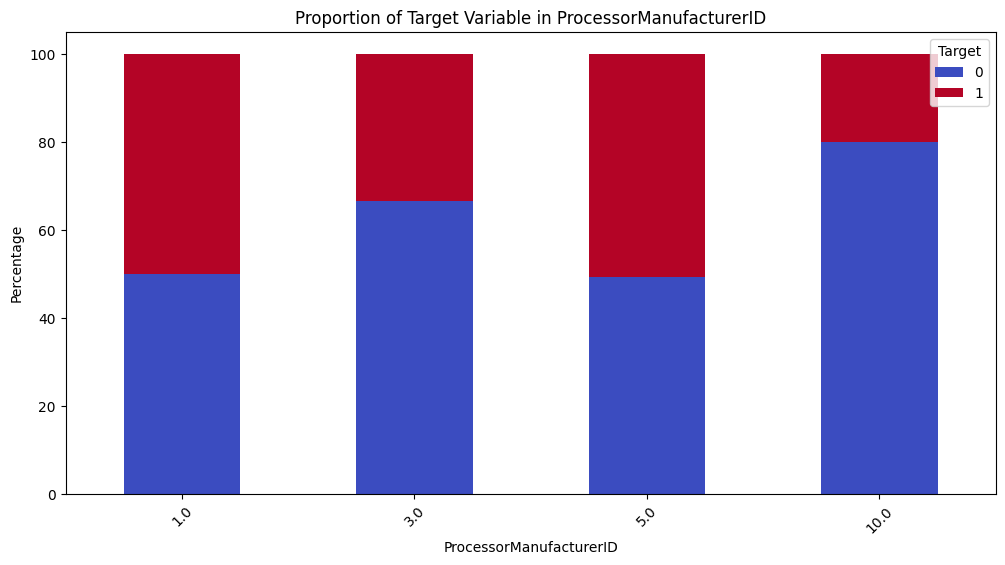

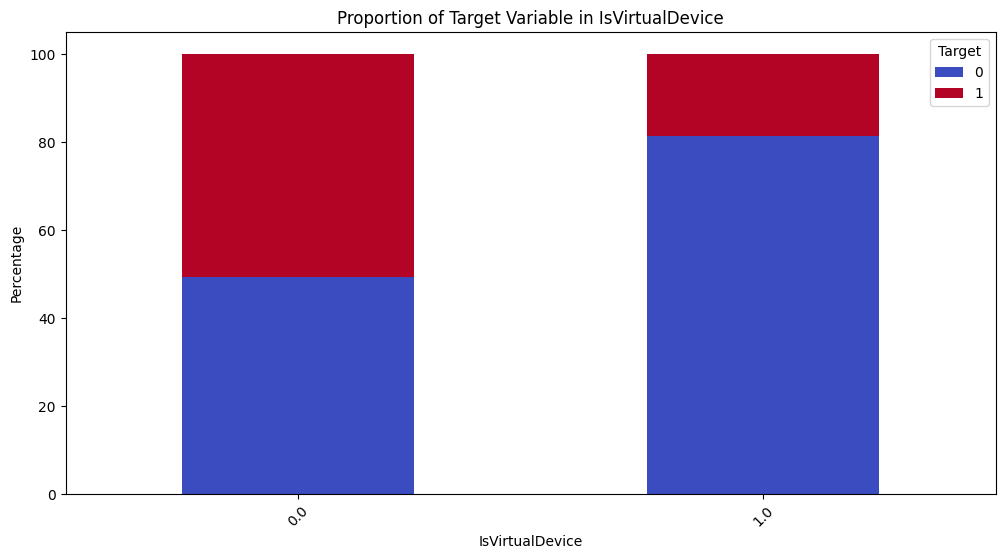

In [13]:
# SELECTED COLUMNS FROM THE NUMERICAL COLUMNS
columns_of_interest=['RealTimeProtectionState','NumAntivirusProductsInstalled','OSProductSuite','SMode',
                     'ProcessorManufacturerID','IsVirtualDevice']
for col in columns_of_interest:
    # # CREATING CROSSTABTAB AND THEN STACKED BAR CHART
    cross_tab = pd.crosstab(df[col], df['target'], normalize='index') * 100
    cross_tab.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')
    plt.title(f"Proportion of Target Variable in {col}")
    plt.xlabel(col)
    plt.ylabel("Percentage")
    plt.xticks(rotation=45)
    plt.legend(title="Target", loc='upper right')
    plt.show()

The following were the observations:

* **RealtimeProtectionState** : **'5'** was the safest state (90%) safe while as **'8'** was most vulnerable (80%) vulnerable.
* **NumAntivirusProductsInstalled** : The vulnerabilty decreases as NumAntivirusProductsInstalled increases- **45% vulnerability for 1 to 20% vulnerability for 5.O**
* **SProductSuite** : **'784'** was fully vulnerable while as **'305' & '400'** were fully secured.
* **IssystemProtected** : The system is **35%** vulnerable if **IssystemProtected=="No"**
* **NoSMode** : The system vulnerability is only **(10%) if enabled**.
* **EnableLUA** : **30%** vulnerability for **'48'**.
* **ProcessorManufacturerID**: only **20%** vulnerability for '**10.0'**.
* **IsVirtualDevice **: **85%** safe if **'yes'.**


In [14]:
'''
# VISUALIZING CATEGORICAL COLUMNS IN THE SAME MANNER
MAX_CATEGORIES = 15

for col in cat_cols:
    unique_values = df[col].nunique()
    
    if unique_values > MAX_CATEGORIES:
        continue
    cross_tab = pd.crosstab(df[col], df['target'], normalize='index')

    cross_tab.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='coolwarm')
    plt.title(f"Stacked Bar Chart for {col} vs Target")
    plt.ylabel("Proportion")
    plt.xticks(rotation=45)
    plt.legend(title="Target")
    plt.show()
'''

'\n# VISUALIZING CATEGORICAL COLUMNS IN THE SAME MANNER\nMAX_CATEGORIES = 15\n\nfor col in cat_cols:\n    unique_values = df[col].nunique()\n    \n    if unique_values > MAX_CATEGORIES:\n        continue\n    cross_tab = pd.crosstab(df[col], df[\'target\'], normalize=\'index\')\n\n    cross_tab.plot(kind=\'bar\', stacked=True, figsize=(14, 6), colormap=\'coolwarm\')\n    plt.title(f"Stacked Bar Chart for {col} vs Target")\n    plt.ylabel("Proportion")\n    plt.xticks(rotation=45)\n    plt.legend(title="Target")\n    plt.show()\n'

**Among all the numerical type columns,the following columns are taken into consideration:**

*PlatformType,Processor,OSVersion,SKUEditionName,MDC2FormFactor,DeviceFamily,PowerPlatformRole,OSArchitecture,AutoUpdateOptionsName,LicenseActivationChannel.*


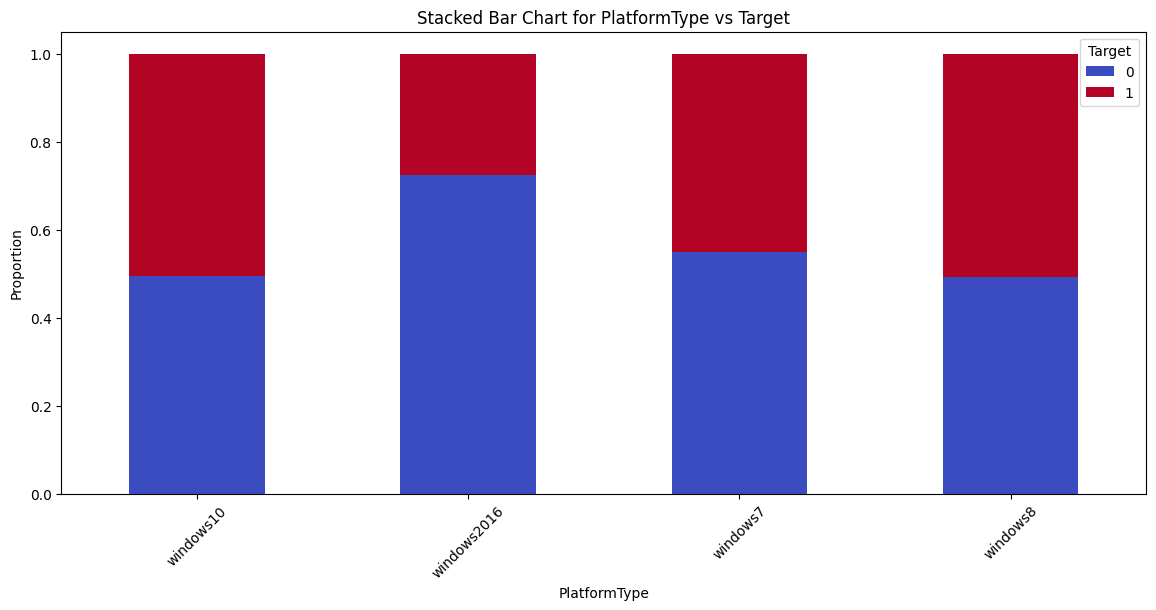

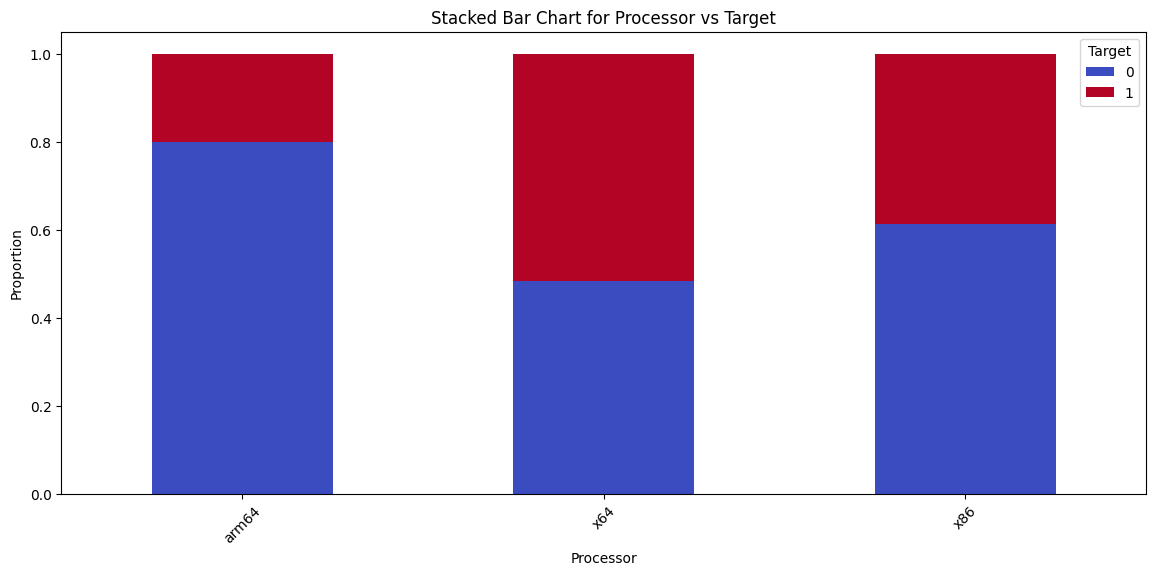

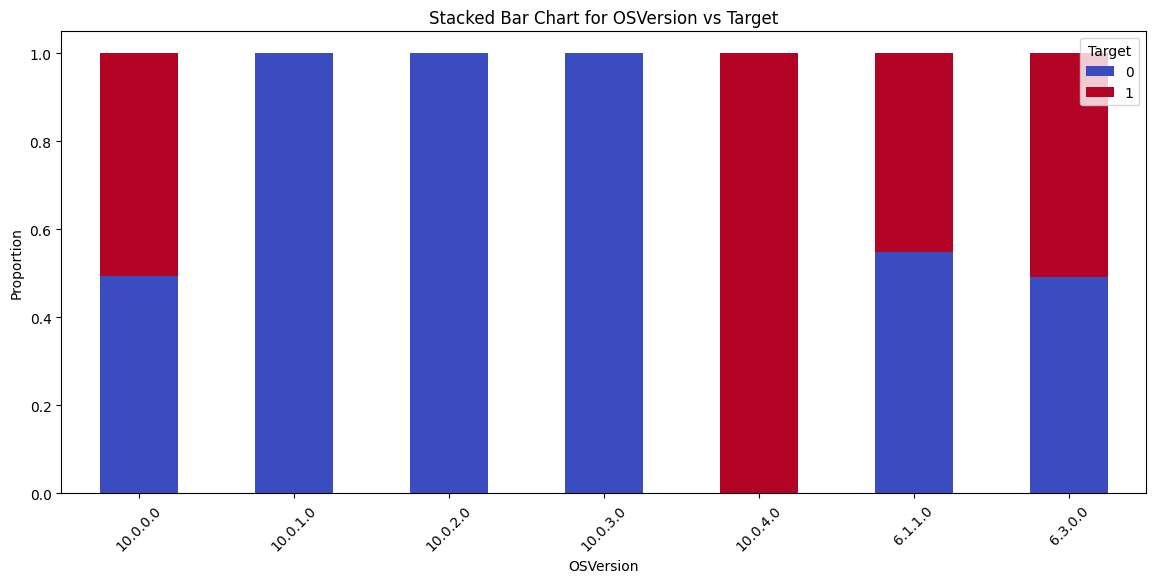

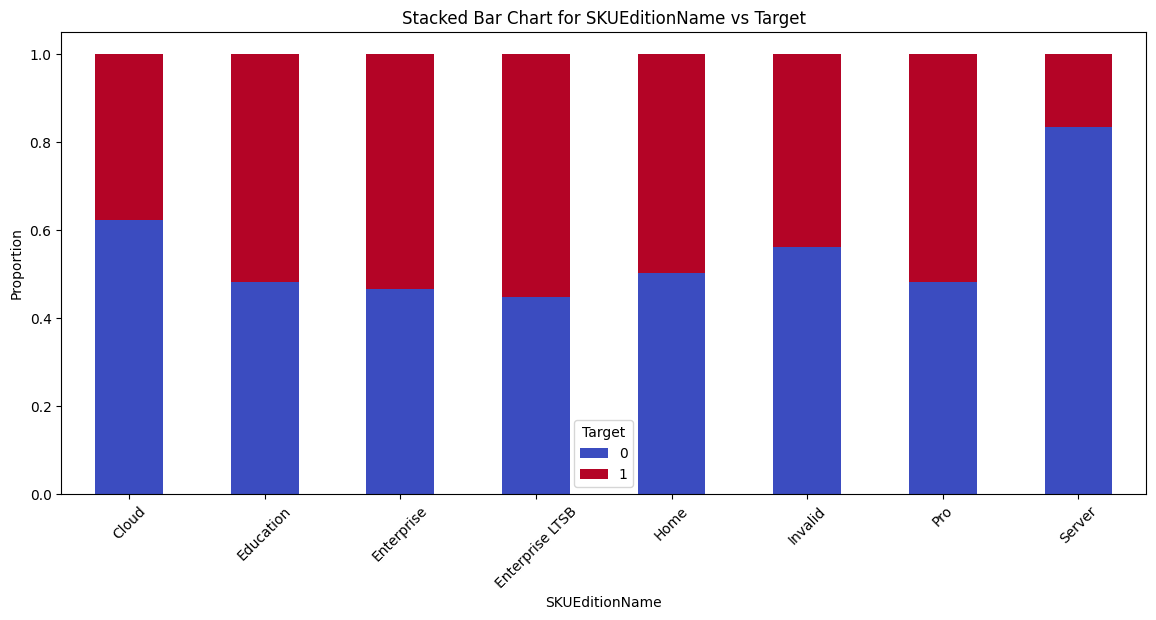

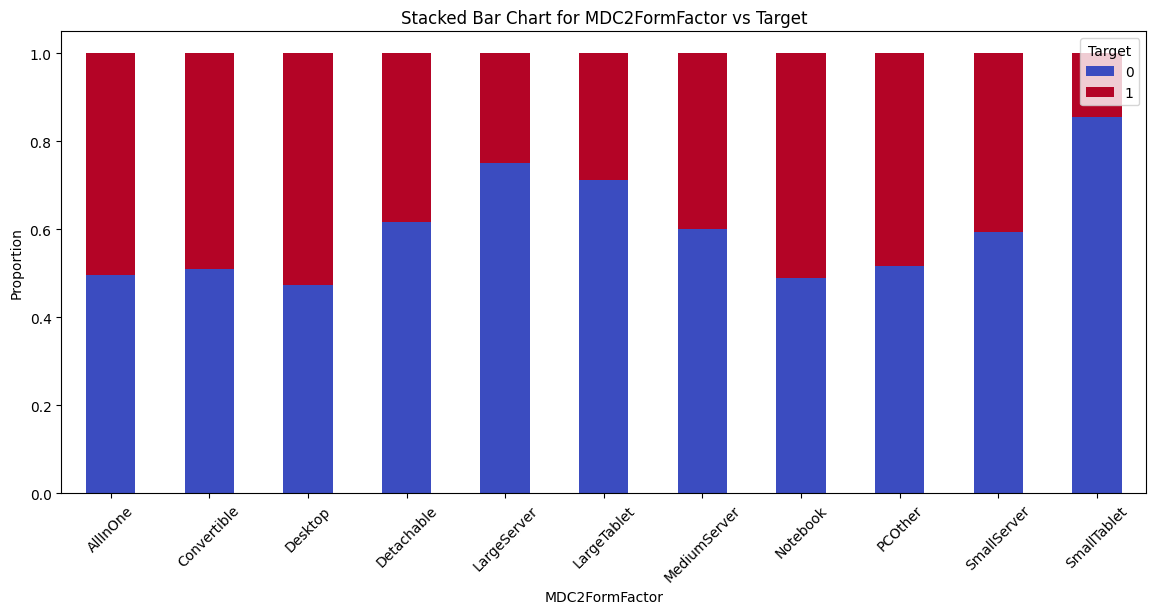

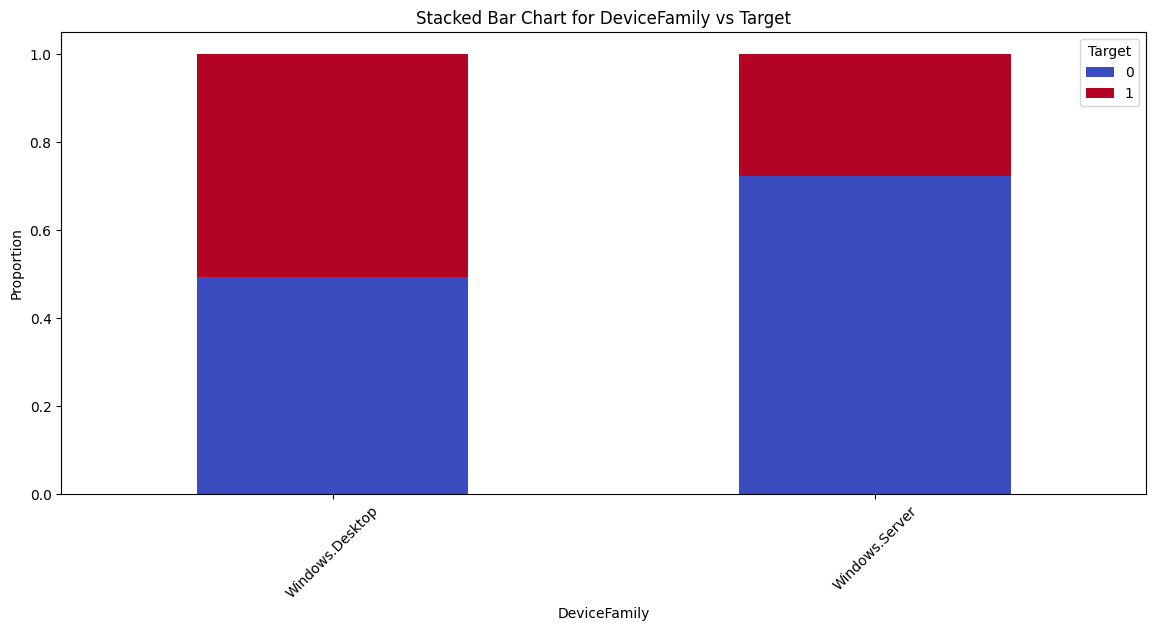

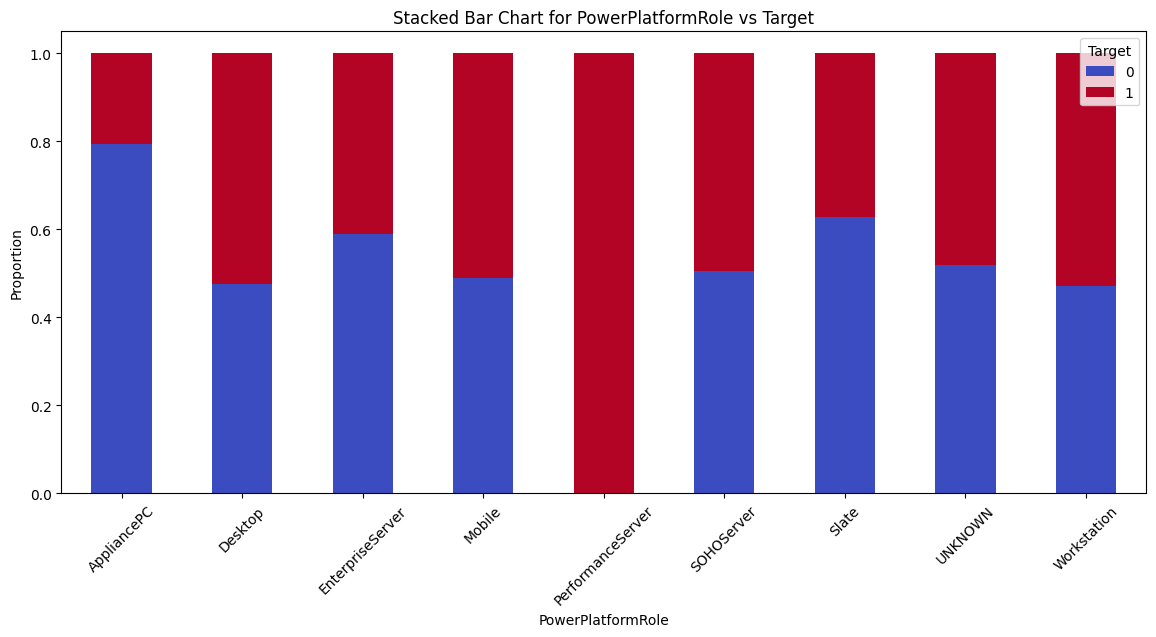

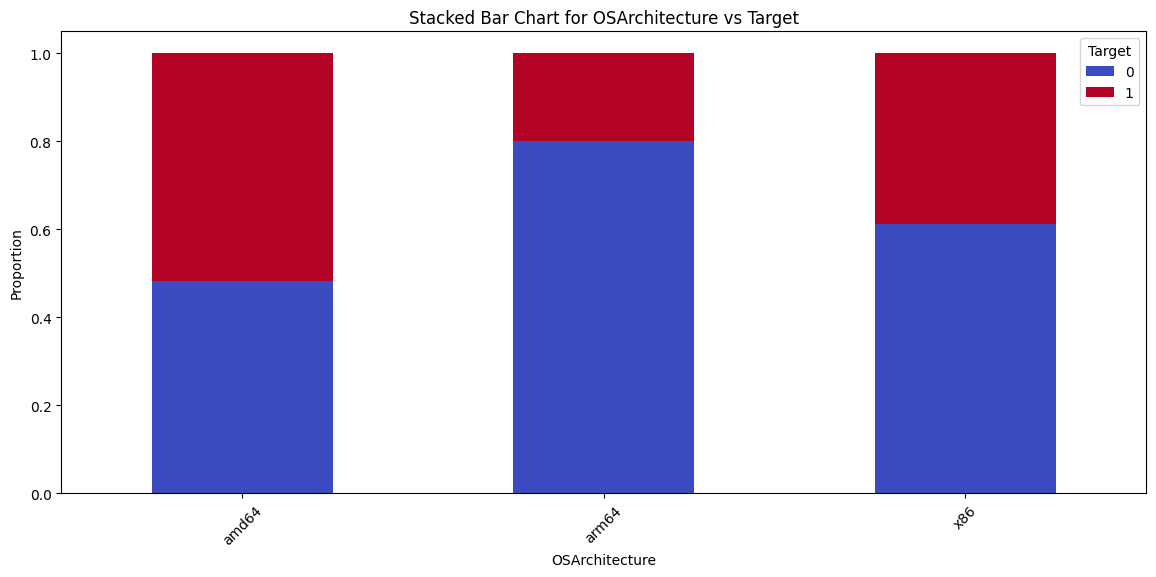

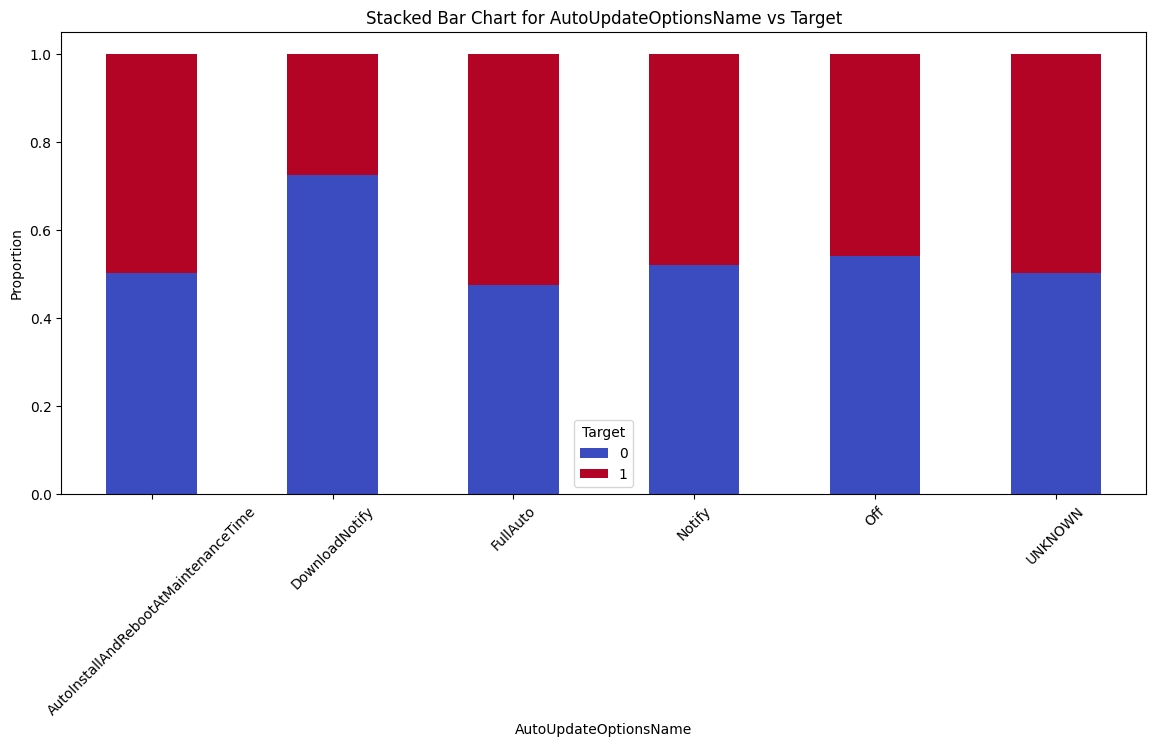

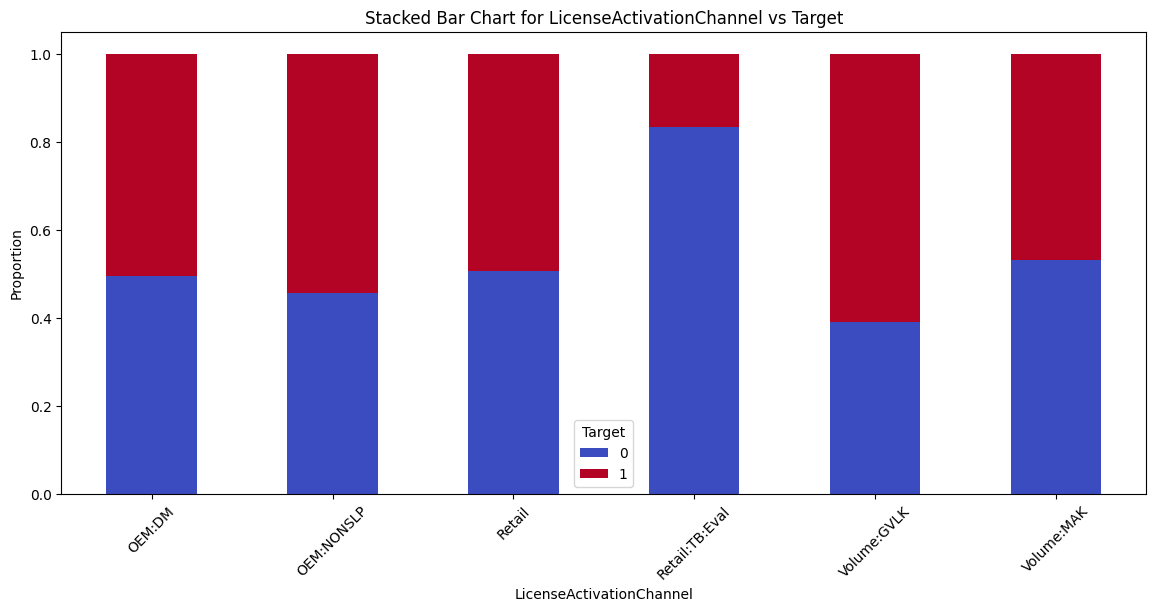

In [15]:
# SELECTING SPECIFIC COLUMNS OF INTEREST
cols_of_interest=['PlatformType','Processor','OSVersion','SKUEditionName','MDC2FormFactor','DeviceFamily'
                  ,'PowerPlatformRole','OSArchitecture','AutoUpdateOptionsName','LicenseActivationChannel']
for col in cols_of_interest:
    cross_tab = pd.crosstab(df[col], df['target'], normalize='index')

    cross_tab.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='coolwarm')
    plt.title(f"Stacked Bar Chart for {col} vs Target")
    plt.ylabel("Proportion")
    plt.xticks(rotation=45)
    plt.legend(title="Target")
    plt.show()

The following observations were made:
* **PlatformType**: **'win64'** was the **safest (70%**).
* **Processor**: **'arm64**' was the **safest (80%)**.
* **OSVersion** - **'10.0.1.0' ,'10.0.2.0' ,'10.0.3.0'** were **fully safe** while as **'10.0.4.0'** showed **full   vulerability**.
* **SKUEditionName** - 'server' was **80% safe**.
* **MDC2FormFactor**- **'smalltablet','largeserver','largetablet'** were **100% vulnerable**.
* **PowerPlatformRole** - **'AppliancePc'** was **80%** safe while as **'PerformanceServer'** was **100% vulnerable**.
* **OSArchitecture** - **'arm64'** was **80% safe**.
* **AutoUpdateOptionsName** - **'DownloadNotify'** was the **safest 75%**.
* **LicenseActivationChannel** - **Retail:TB:Eval** was **safest (90%)**.

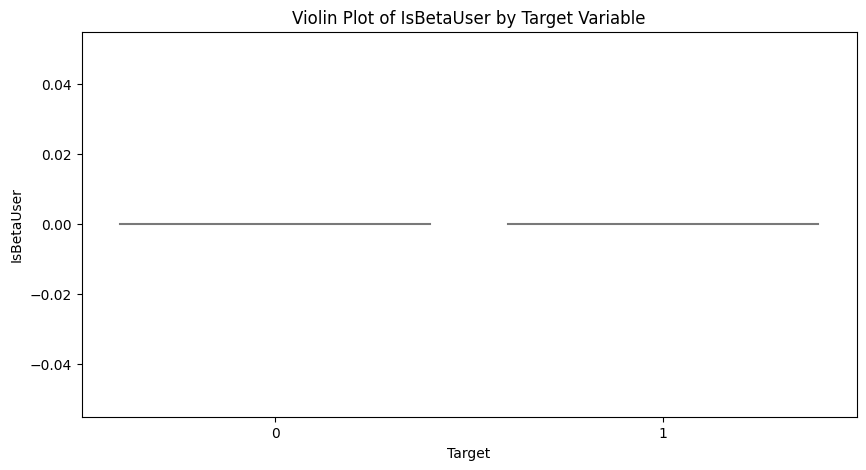

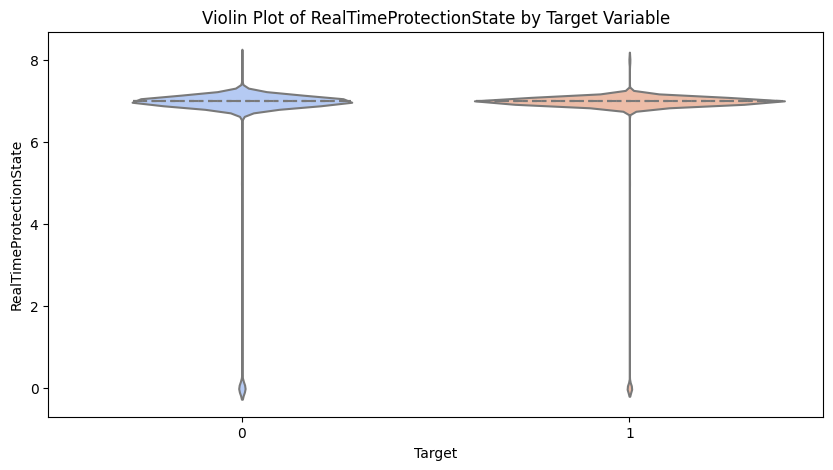

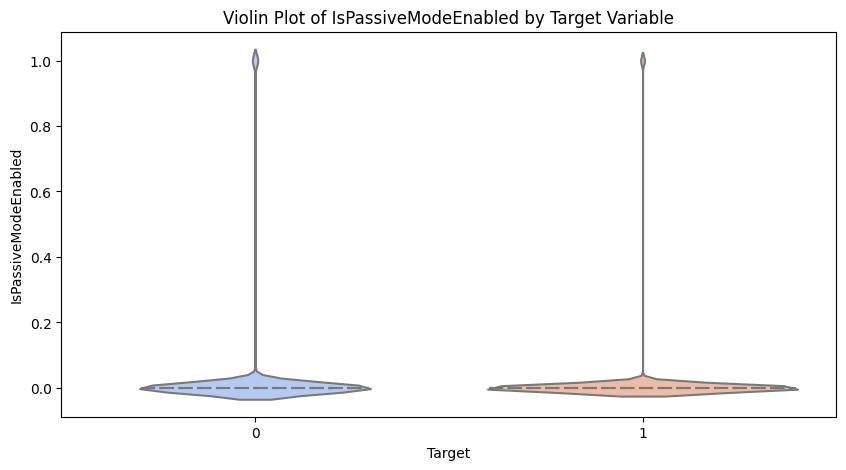

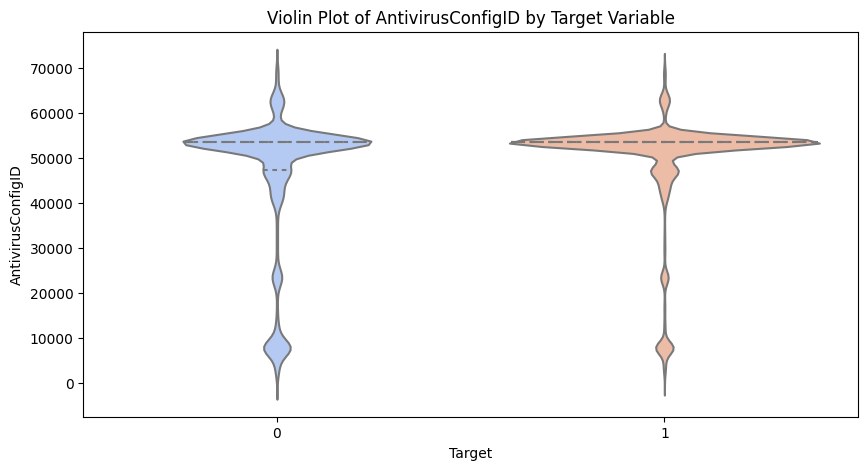

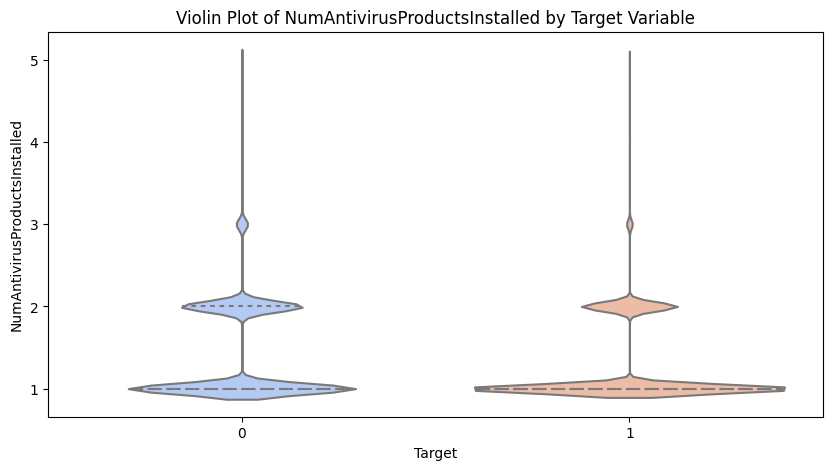

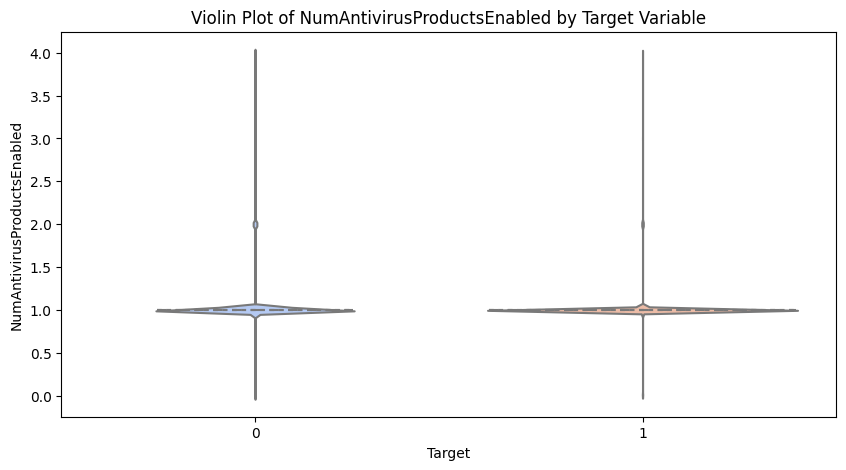

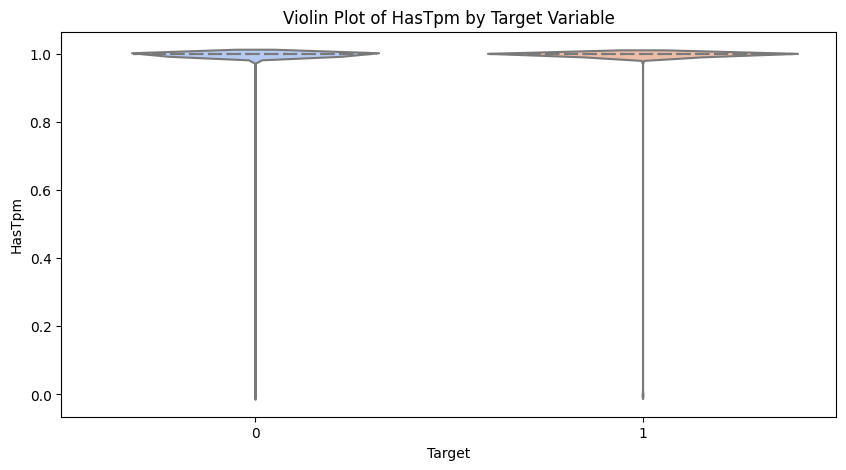

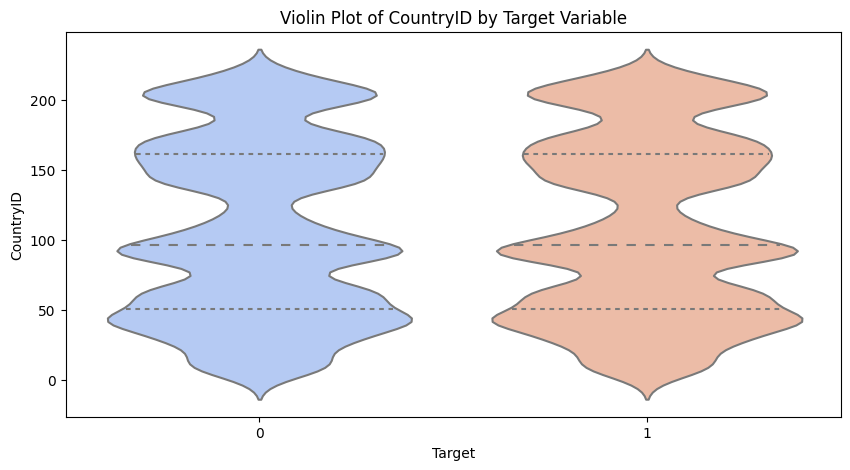

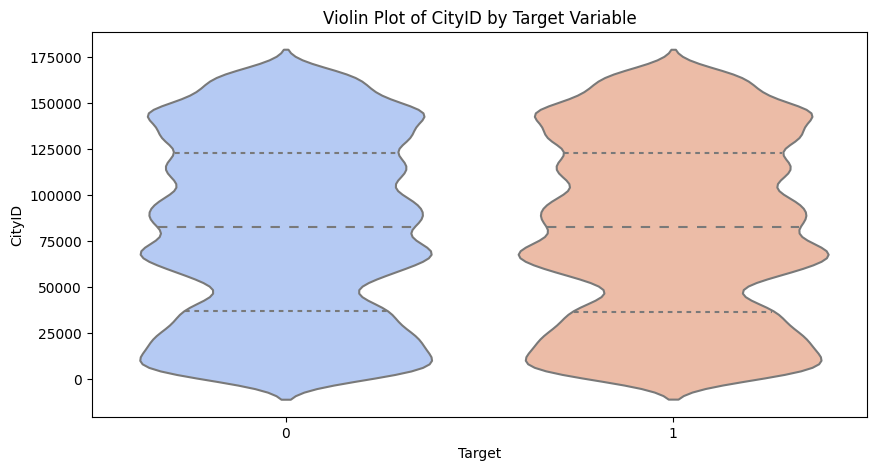

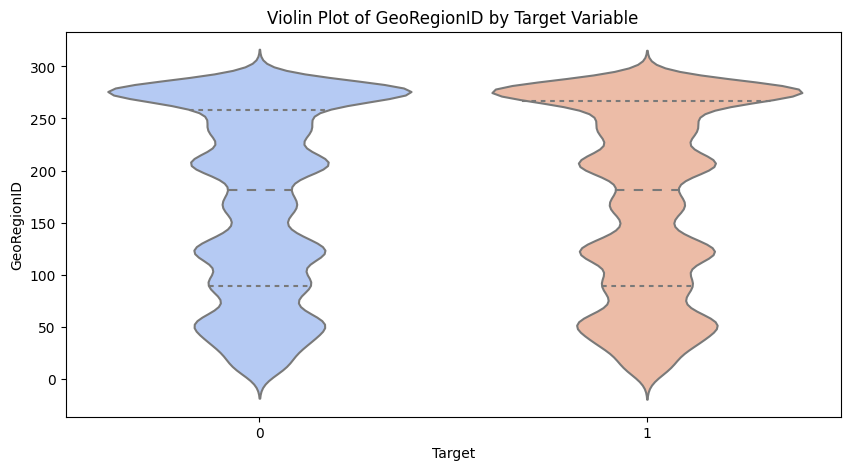

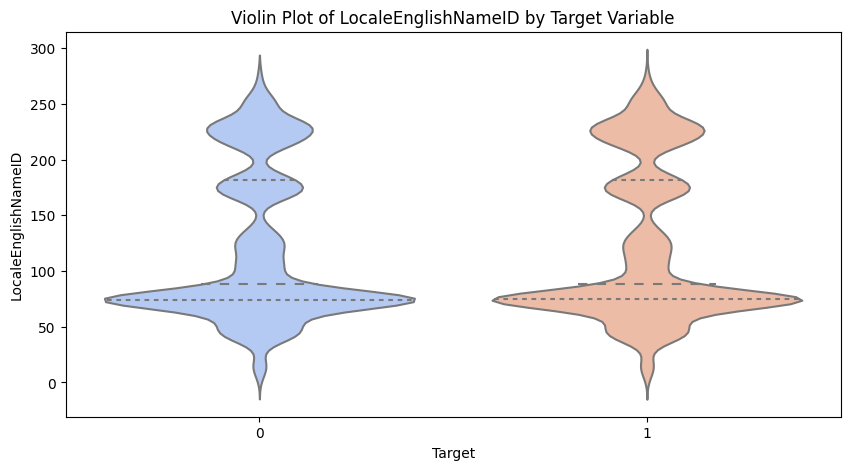

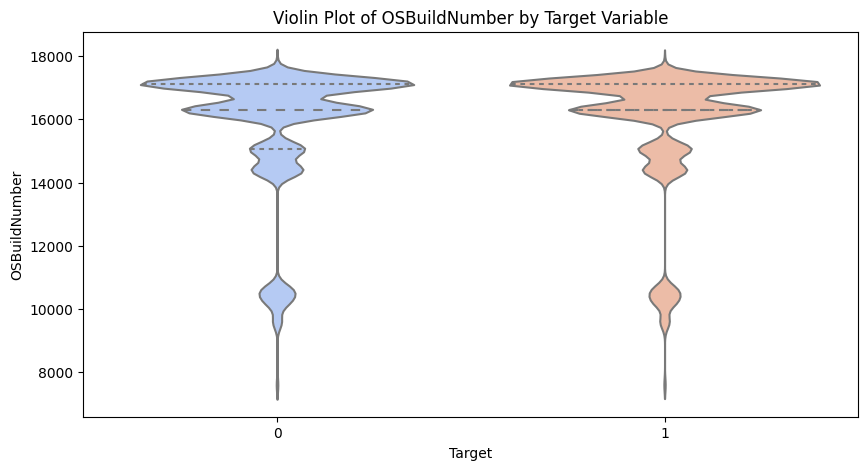

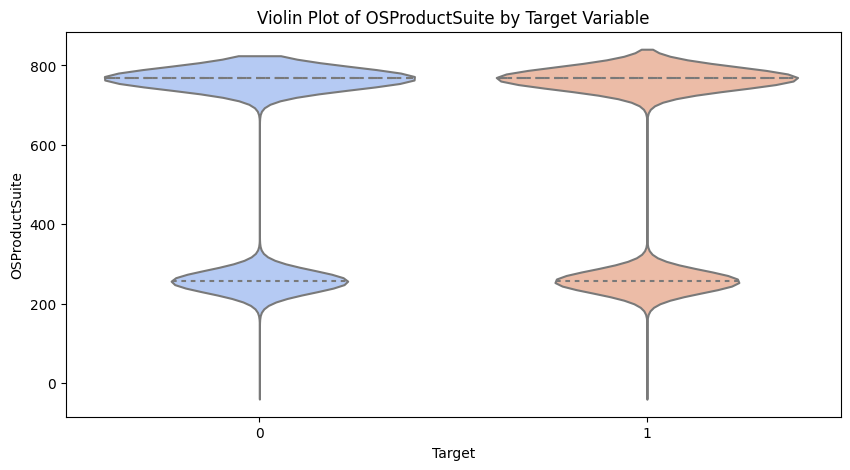

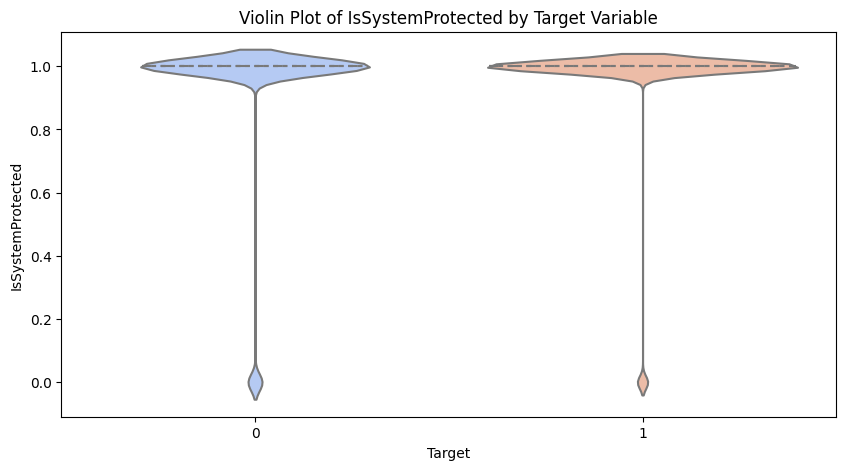

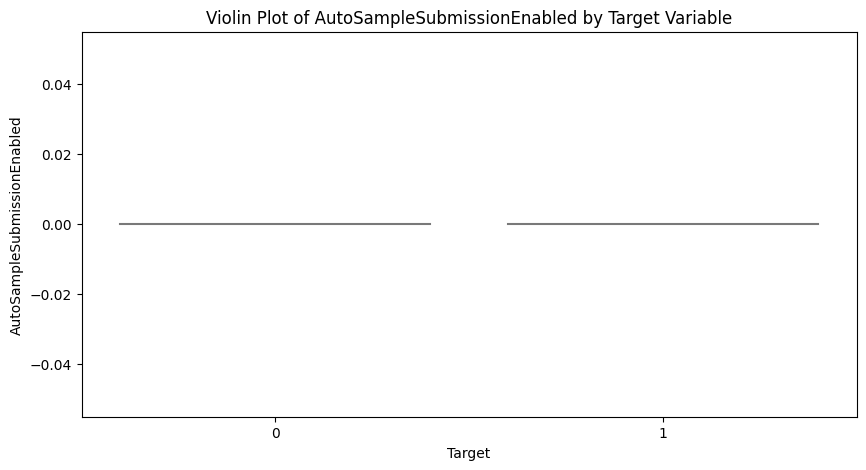

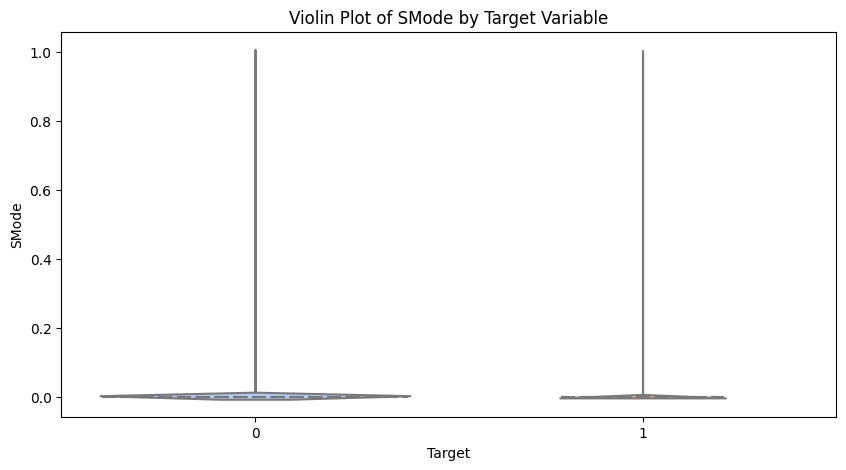

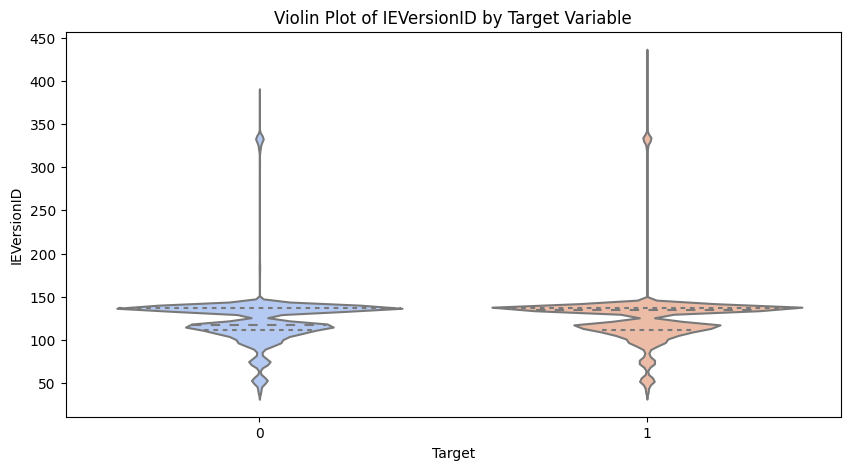

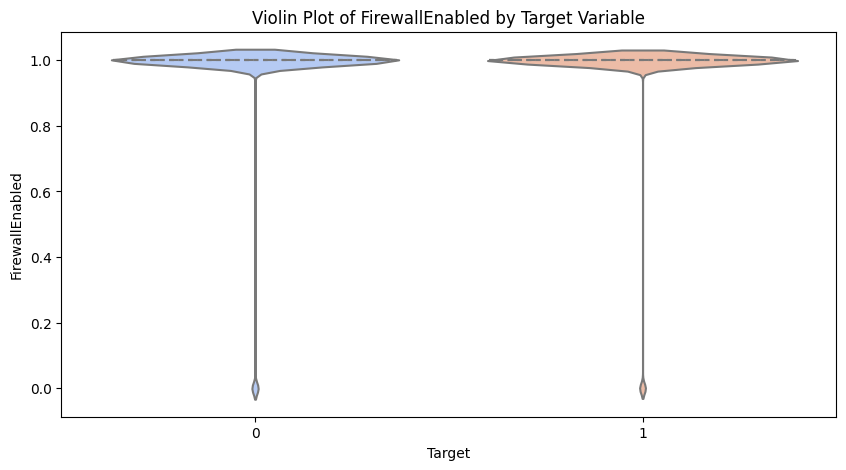

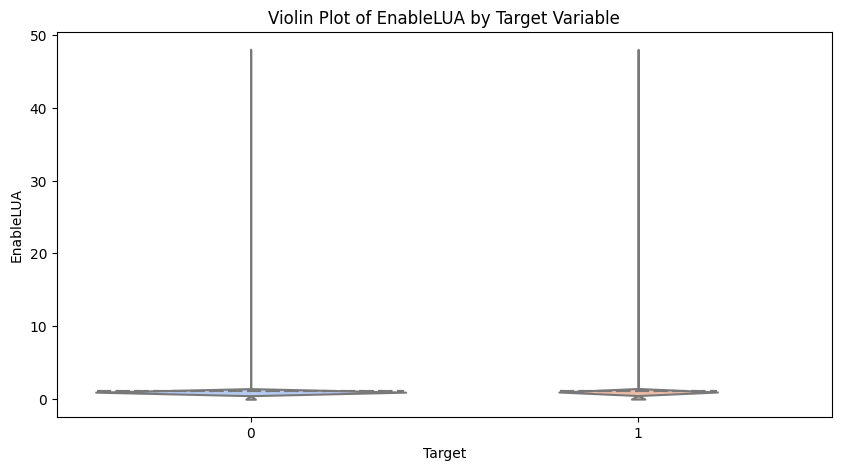

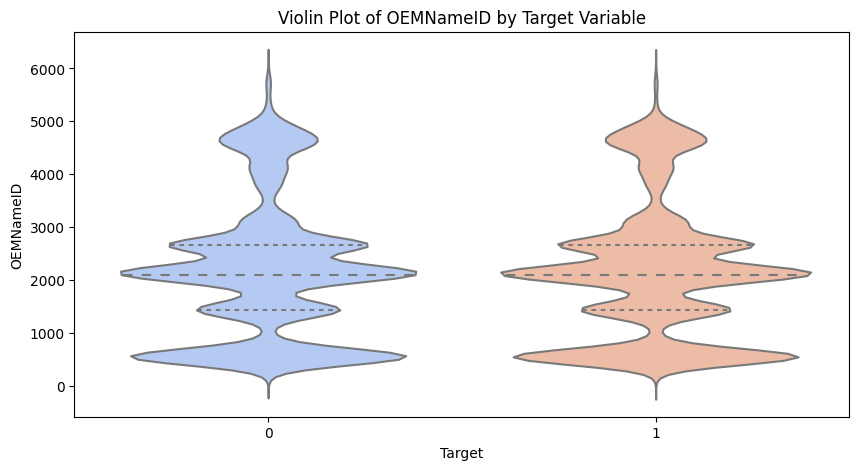

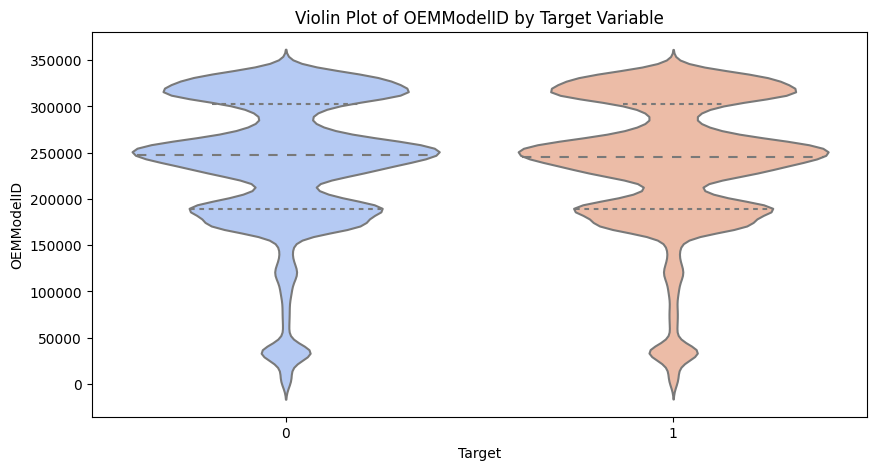

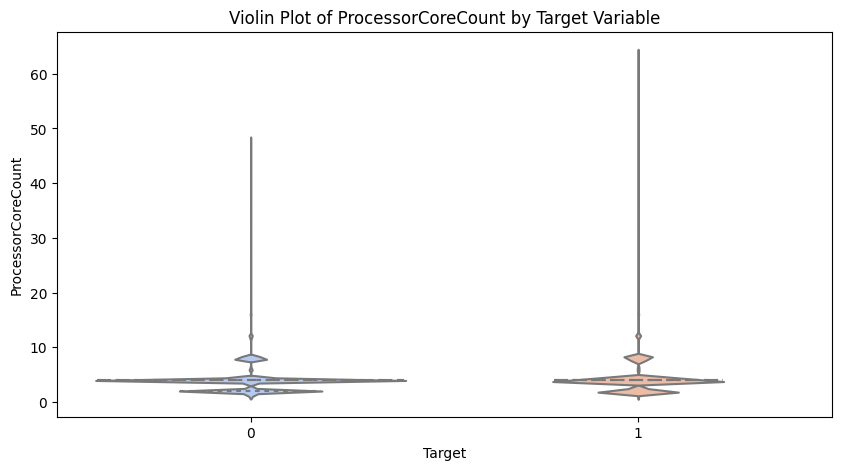

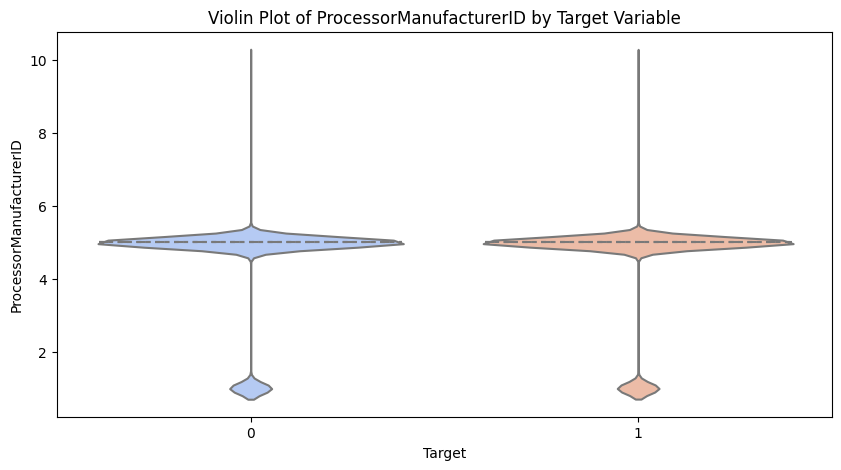

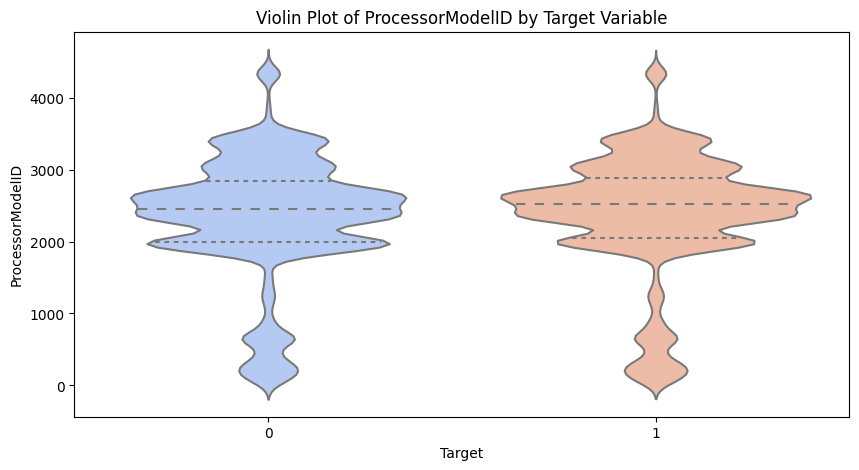

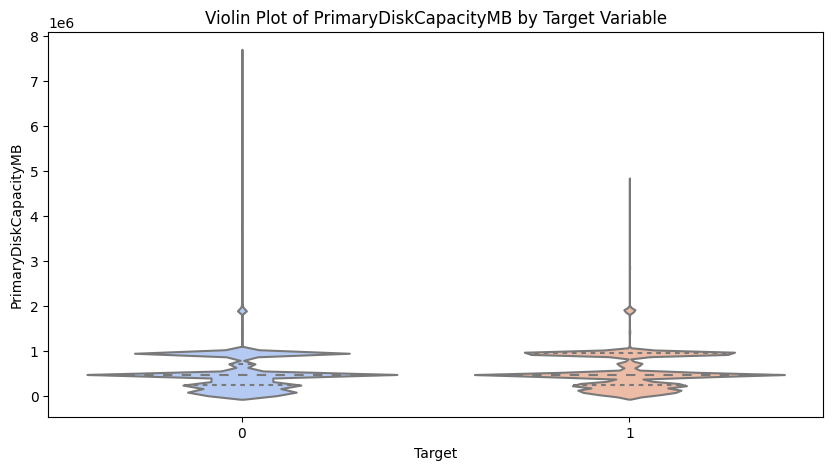

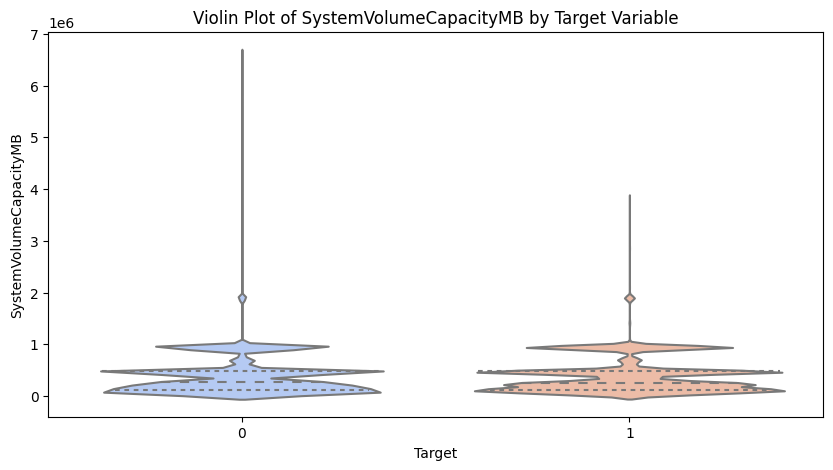

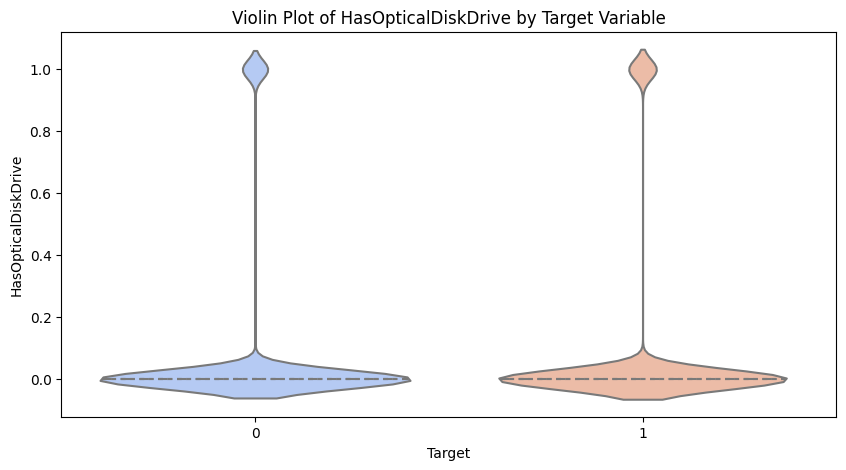

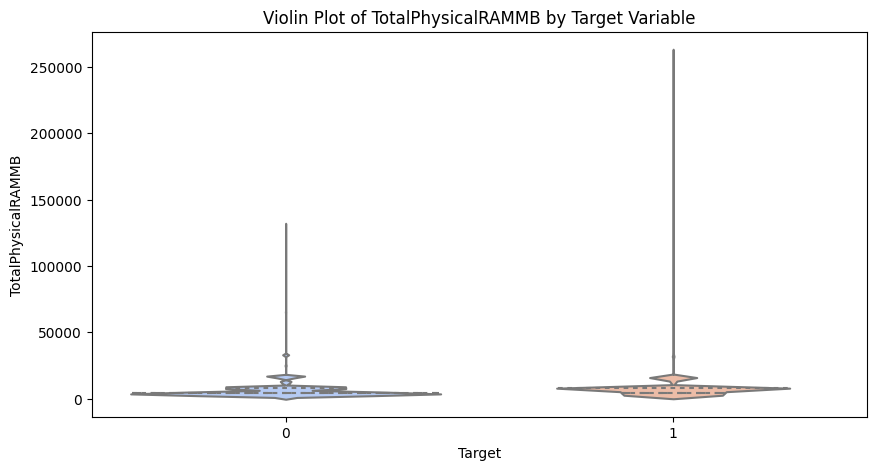

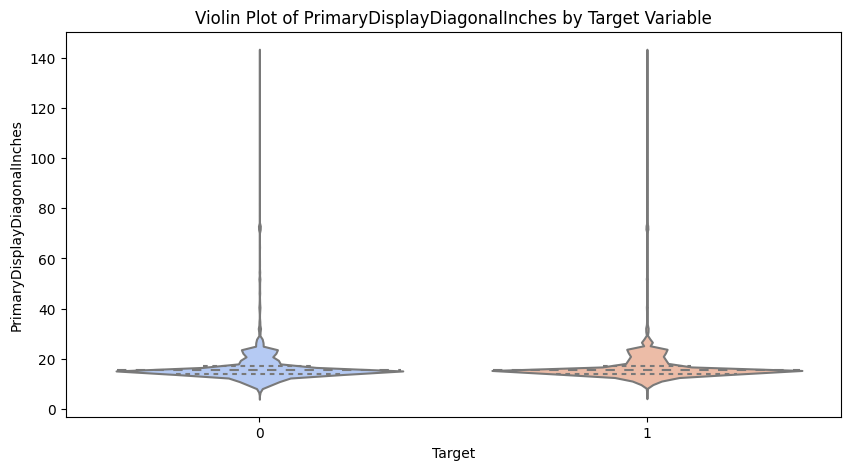

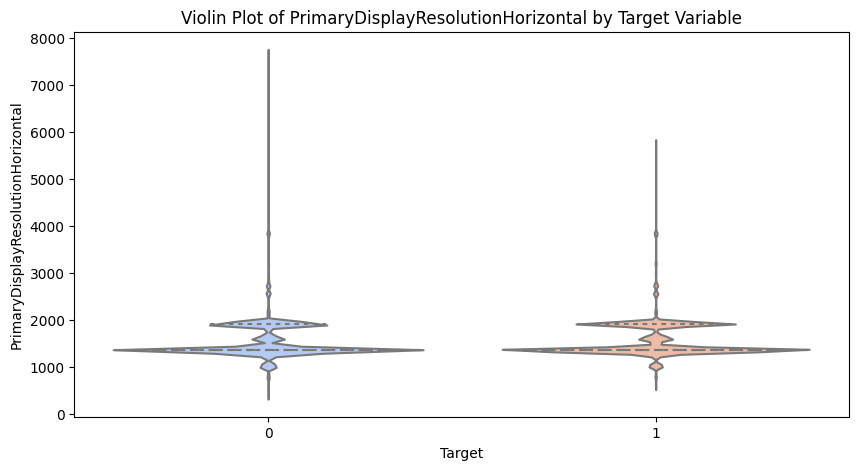

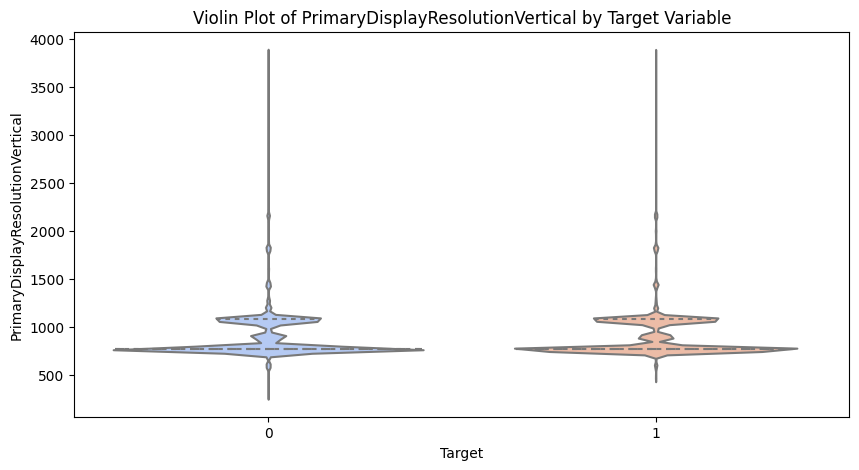

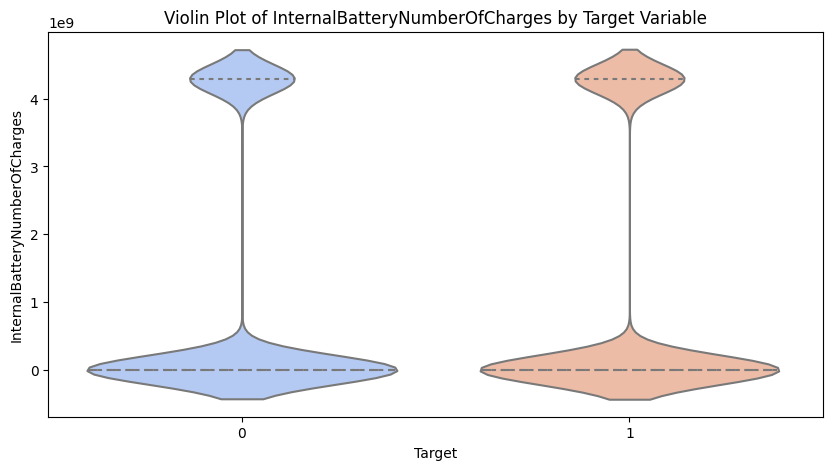

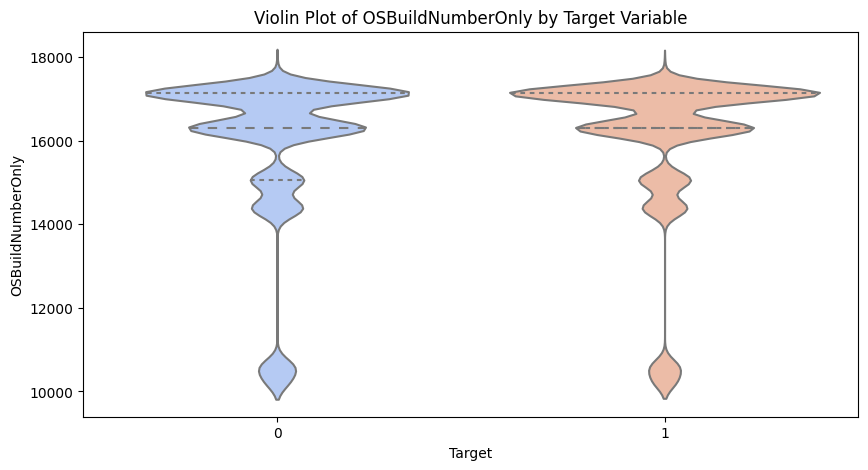

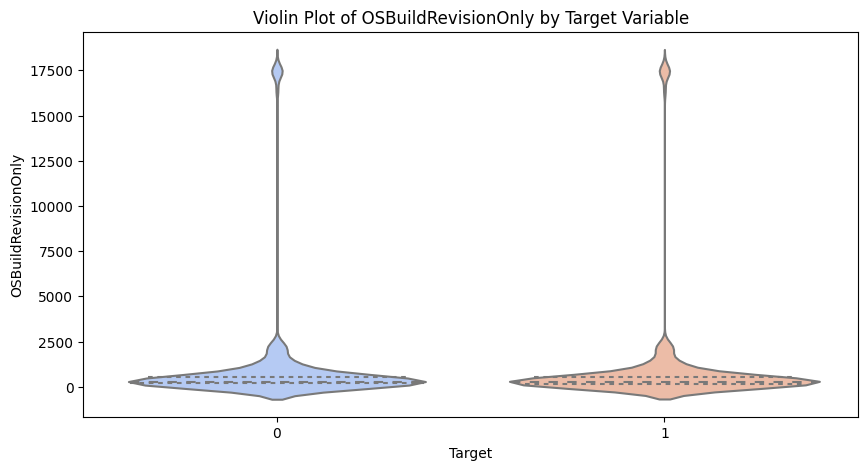

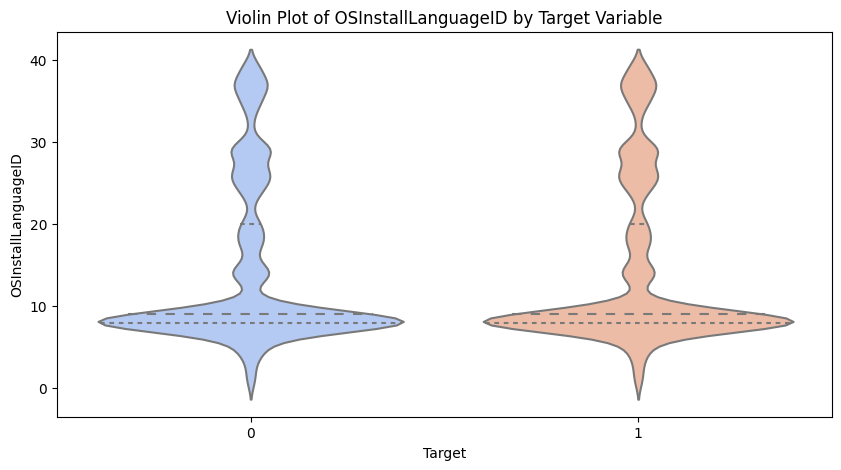

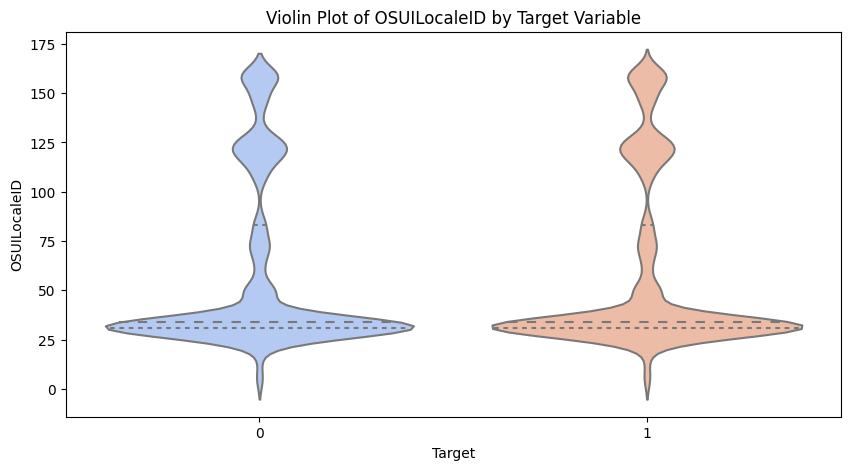

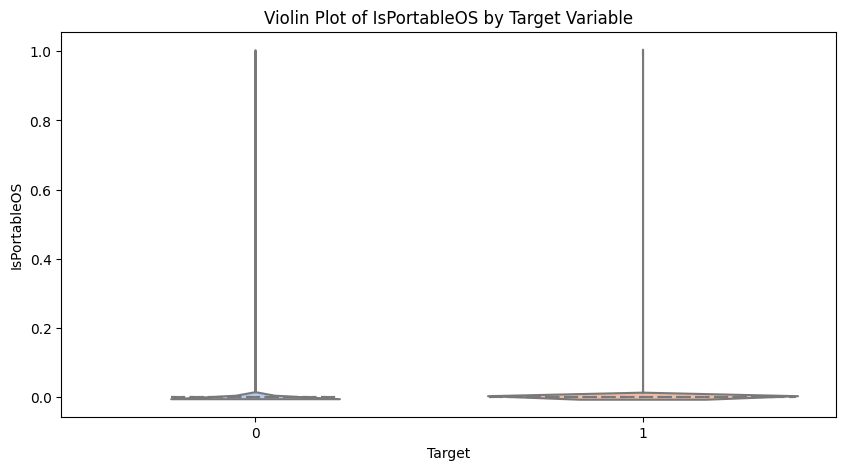

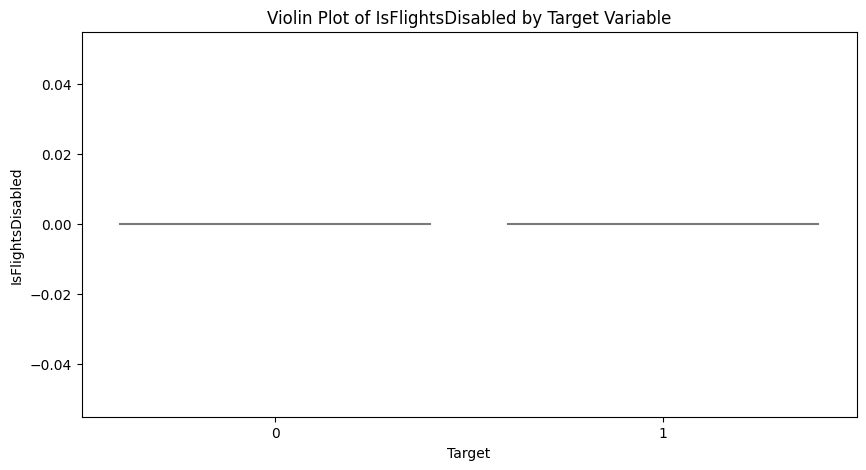

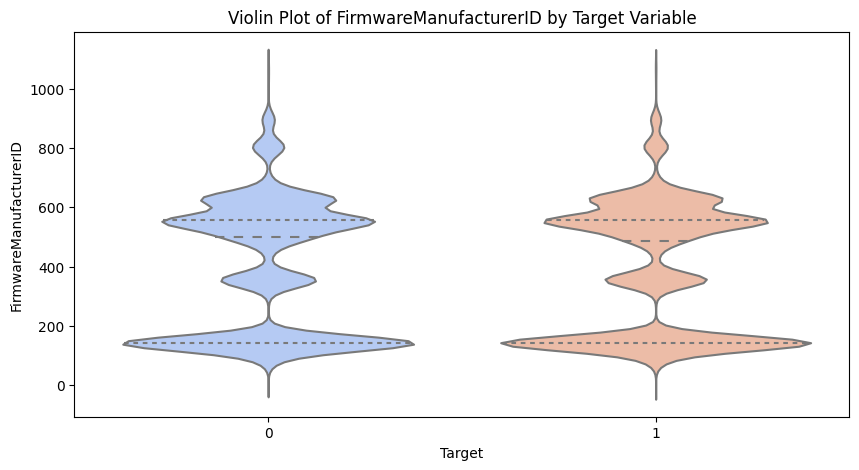

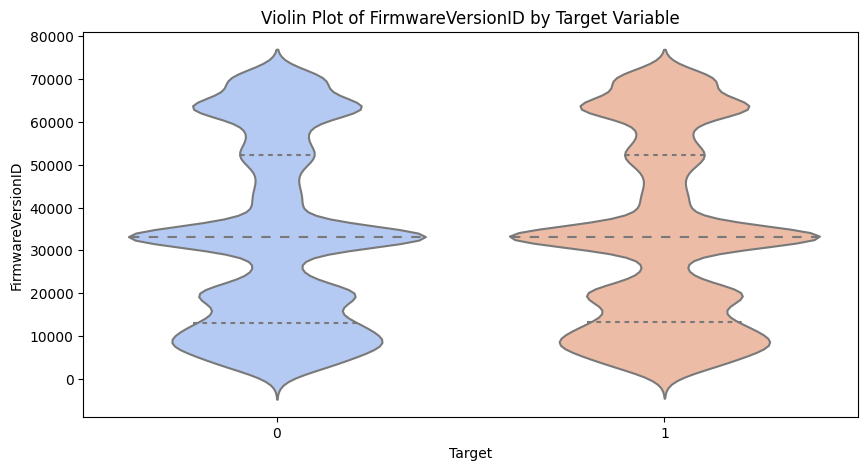

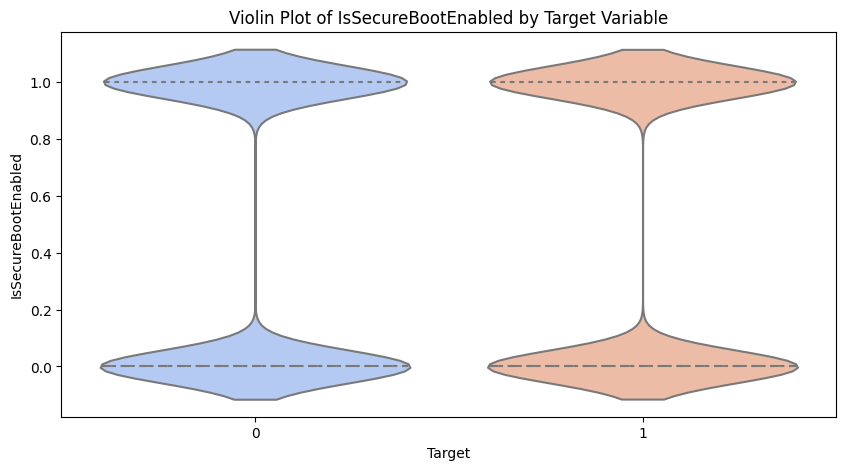

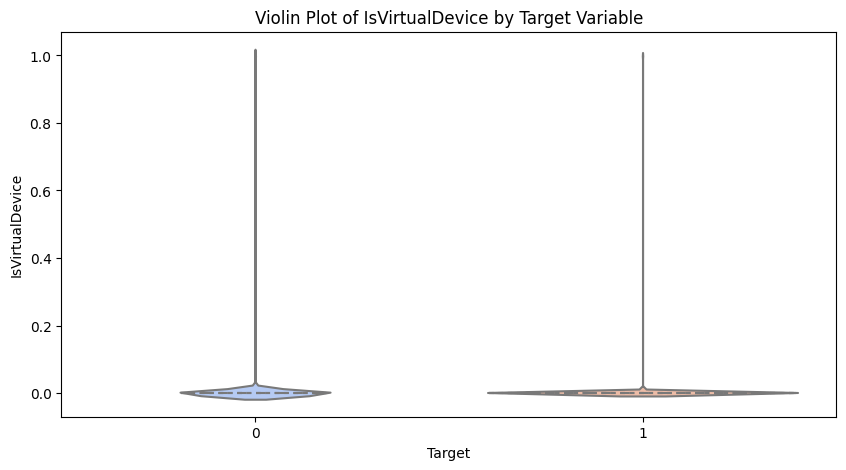

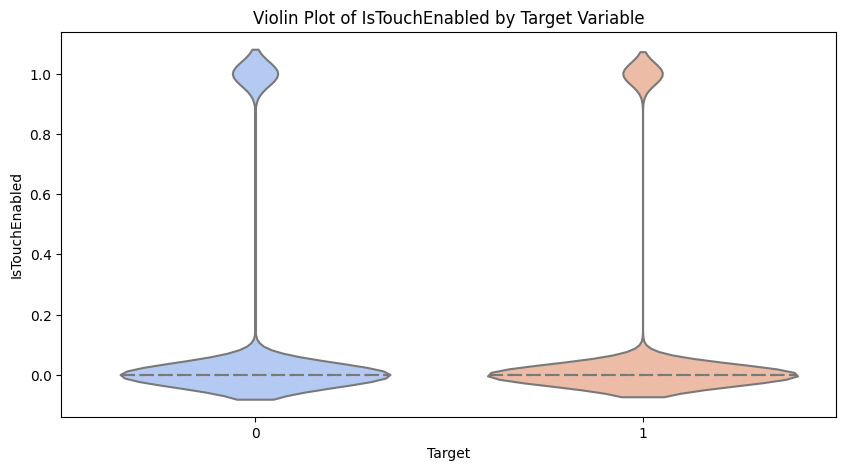

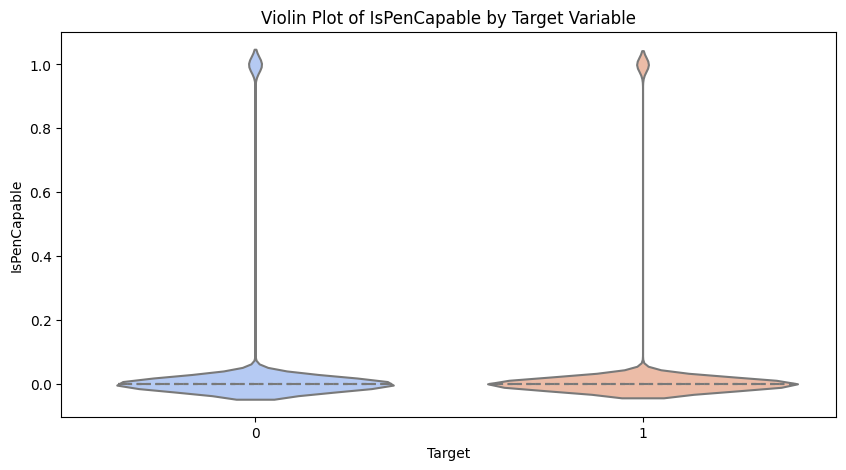

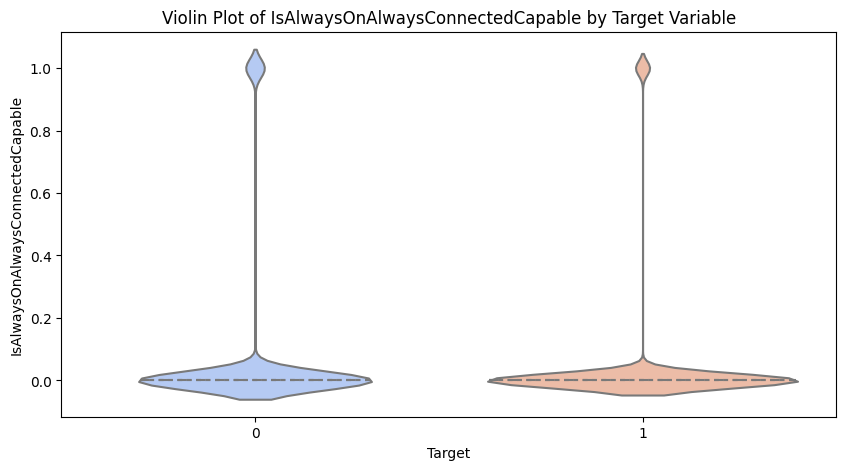

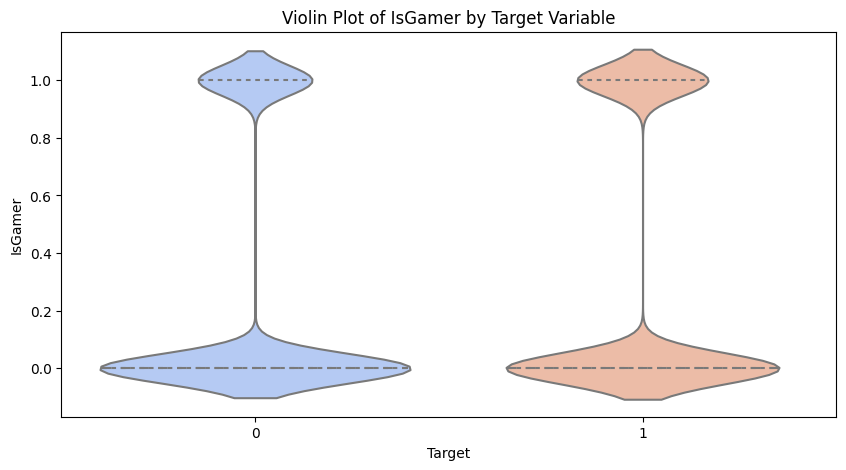

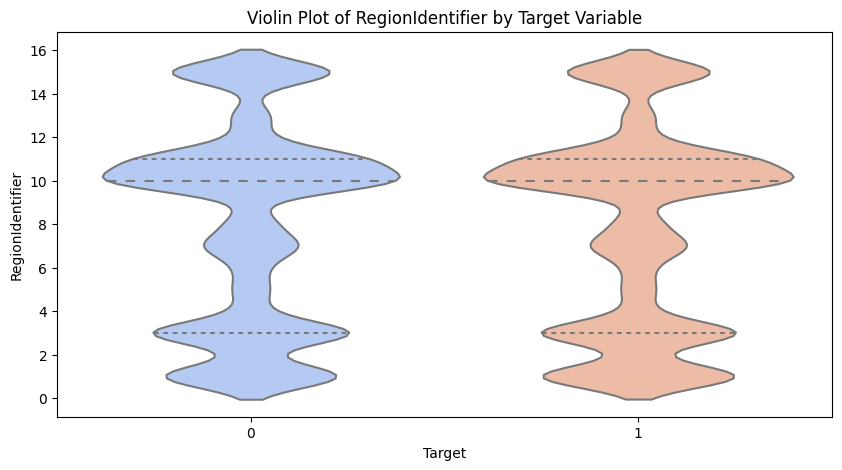

In [16]:
### OUTLIERS VISUALIZATION
import seaborn as sns
for col in num_cols:
    plt.figure(figsize=(10, 5))
    
    sns.violinplot(data=df, x='target', y=col, palette="coolwarm", inner="quartile")
    
    plt.title(f"Violin Plot of {col} by Target Variable")
    plt.xlabel("Target")
    plt.ylabel(col)
    plt.show()

# PREPROCESSING & FEATURE ENGINEERING

In [17]:
# SEPARATING CATEGORICAL COLUMNS BASED ON NUMBER OF UNIQUE VALUES
ordinal_cols = [col for col in cat_cols if df[col].nunique() > 9]
onehot_cols = [col for col in cat_cols if df[col].nunique() <= 9]

In [18]:
# CREATING SEPARATE PIPELINES FOR NUMERICAL, ORDINAL & CATEGORICAL COLUMNS

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', MinMaxScaler())
])

ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

onehot_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


In [19]:
# CREATING AND EMPTY LIST OF TRANSFORMERS AND THEN APPENDING BASED ON THE TYPE OF COLUMNS
transformers = []
if num_cols:
    transformers.append(('num', num_pipeline, num_cols))
if ordinal_cols:
    transformers.append(('ord', ordinal_pipeline, ordinal_cols))
if onehot_cols:
    transformers.append(('ohe', onehot_pipeline, onehot_cols))

transformer = ColumnTransformer(transformers)

In [20]:
# SINCE DATASET IS ALMOST BALANCED TRAIN-TEST SPLIT IS A GOOD CHOICE FOR SPLITTING AND VALIDATION
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# APPLYING TRANSFORMATION TO THE DATA
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)
X_transformed = transformer.transform(X)  
df2_transformed = transformer.transform(df2[X.columns])

# HYPER-PARAMETER TUNING & MODEL BUILDING

In [21]:
# THE MODEL WAS TUNED BASED ON THE BELOW CODE AND THEN THE MODEL WAS TRAINED BASED ON THOSE BEST PARAMS
'''
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 16, 20],
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters and retraining with the best model
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
'''

'\nfrom sklearn.model_selection import GridSearchCV\n\n# Hyperparameter tuning using GridSearchCV\nparam_grid = {\n    \'n_estimators\': [100, 200],\n    \'max_depth\': [10, 16, 20],\n}\n\nrf = RandomForestClassifier(random_state=42, n_jobs=-1)\ngrid_search = GridSearchCV(rf, param_grid, cv=5, scoring=\'accuracy\', n_jobs=-1, verbose=1)\ngrid_search.fit(X_train, y_train)\n\n# Best parameters and retraining with the best model\nbest_params = grid_search.best_params_\nprint("Best Parameters:", best_params)\n'

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'max_depth': 20, 'n_estimators': 200}
The inital set of estimators were :'n_estimators': [100, 200],'max_depth': [10, 16, 20],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]. But the accuracy was reduced due to those hyperparameter values.
**THE BEST PARAMS OBTAINED HERE WERE THEN USED TO TRAIN THE RANDOM FOREST CLASSIFIER MODEL**

In [22]:
## RANDOM FOREST CLASSIFIER #1
## HIGHEST ACCURACY OBTAINED TILL NOW
model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1)
model.fit(X_transformed, y)
y_pred = model.predict(df2_transformed)
#y_pred = model.predict(X_test)
#acc= accuracy_score(y_pred=y_pred,y_true=y_test)
#print(f"accuracy:{acc}")

The accuracy obtained from this model on validation set is: **0.9003856362998949**


In [23]:
# FILE SUBMISSION FOR THE TEST SET
submission = pd.DataFrame({"id": range(len(df2)), "target": y_pred})
submission.to_csv('submission.csv', index=False)

In [24]:
from sklearn.metrics import accuracy_score
## RIDGE CLASSIFIER #2
model = RidgeClassifier(random_state=42)
model.fit(X_transformed, y)
y_pred = model.predict(X_test)
acc= accuracy_score(y_pred=y_pred,y_true=y_test)
print(f"ridge:{acc}")

ridge:0.6057494866529775


The accuracy obtained from this model on validation set is: **0.6057494866529775**

In [25]:
## SGD CLASSIFIER #3
SGD=SGDClassifier(random_state=42)
SGD.fit(X_train,y_train)
y_pred=SGD.predict(X_test)
acc= accuracy_score(y_pred=y_pred,y_true=y_test)
print(f"SGD:{acc}")

SGD:0.5148495016777683


The accuracy obtained from this model on validation set is: **0.5148495016777683**